In [64]:
import sys
import importlib
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')

from __init__ import *
import __init__jupyterlab
importlib.reload(__init__jupyterlab)
from __init__jupyterlab import *
from matplotlib.ticker import MaxNLocator
from matplotlib.patches import Rectangle

import collections
import itertools
import tables
from adjustText import adjust_text

from scipy import sparse
from scipy import stats
from scipy import optimize 
import scipy.cluster.hierarchy as sch
import fbpca
# import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

import snmcseq_utils
importlib.reload(snmcseq_utils)
import CEMBA_clst_utils
importlib.reload(CEMBA_clst_utils)



<module 'CEMBA_clst_utils' from '/cndd/fangming/CEMBA/snmcseq_dev/CEMBA_clst_utils.py'>

### Enhancer-gene project pilot notebook


- mCG (not normalized, cluster level)
- RNA logTPM (normalized, cluster level) 
- mCH normalized by global mean (normalized, cluster level)
- ATAC logTPM (normalized, cluster level)


## Basic settings 

- gene annotation
- cluster annotation
- enhancers annotation
- gene features
- enhancer features

In [2]:
import datetime
today = datetime.date.today().strftime("%y%m%d")

output_figures = '/cndd2/fangming/scf_enhancers/results/figures/{}_{{}}.{{}}'.format(today)
output_results = '/cndd2/fangming/scf_enhancers/results/{}_{{}}'.format(today)


In [3]:
f = '/cndd/Public_Datasets/CEMBA/snmCSeq/References/Annotation/gencode.vM16.annotation_genes.tsv'
df_genes = pd.read_csv(f, sep='\t')
df_genes['chrom'] = df_genes['chr'].apply(lambda x: x[3:])
df_genes = df_genes[df_genes['chrom'].isin(snmcseq_utils.get_mouse_chromosomes())]
df_genes['gid'] = df_genes['gene_id'].apply(lambda x: x.split('.')[0])
df_genes['length'] = df_genes['end'] - df_genes['start']
print(df_genes.shape)
df_genes.head()

(51772, 10)


,gene_id,gene_name,chr,start,end,strand,gene_type,chrom,gid,length
0,ENSMUSG00000102693.1,4933401J01Rik,chr1,3073253,3074322,+,TEC,1,ENSMUSG00000102693,1069
1,ENSMUSG00000064842.1,Gm26206,chr1,3102016,3102125,+,snRNA,1,ENSMUSG00000064842,109
2,ENSMUSG00000051951.5,Xkr4,chr1,3205901,3671498,-,protein_coding,1,ENSMUSG00000051951,465597
3,ENSMUSG00000102851.1,Gm18956,chr1,3252757,3253236,+,processed_pseudogene,1,ENSMUSG00000102851,479
4,ENSMUSG00000103377.1,Gm37180,chr1,3365731,3368549,-,TEC,1,ENSMUSG00000103377,2818


In [4]:
df_genes_v2 = df_genes.groupby('gene_name').first()
df_genes_v2['chrom'] = df_genes_v2['chr'].apply(lambda x: (x[3:]))
gid_to_name = df_genes.set_index('gid')['gene_name']
df_genes_v2.head()

,gene_id,chr,start,end,strand,gene_type,chrom,gid,length
gene_name,,,,,,,,,
0610005C13Rik,ENSMUSG00000109644.1,chr7,45567794,45575327,-,antisense_RNA,7,ENSMUSG00000109644,7533
0610006L08Rik,ENSMUSG00000108652.1,chr7,74818818,74853813,-,lincRNA,7,ENSMUSG00000108652,34995
0610009B22Rik,ENSMUSG00000007777.9,chr11,51685386,51688874,-,protein_coding,11,ENSMUSG00000007777,3488
0610009E02Rik,ENSMUSG00000086714.1,chr2,26445696,26459390,+,processed_transcript,2,ENSMUSG00000086714,13694
0610009L18Rik,ENSMUSG00000043644.4,chr11,120348678,120351190,+,bidirectional_promoter_lncRNA,11,ENSMUSG00000043644,2512


In [5]:
gid_to_name.head()

gid
ENSMUSG00000102693    4933401J01Rik
ENSMUSG00000064842          Gm26206
ENSMUSG00000051951             Xkr4
ENSMUSG00000102851          Gm18956
ENSMUSG00000103377          Gm37180
Name: gene_name, dtype: object

In [6]:
data_dir = '/cndd2/fangming/projects/scf_enhancers/enhancer_round2_191211/'

In [7]:
# list of enhancers
f = os.path.join(data_dir, 'results/enhancers.bed')
df_enhs = pd.read_csv(f, sep='\t', header=None, names=['chr', 'start', 'end', 'clsts'])
df_enhs['length'] = df_enhs['end'] - df_enhs['start']
df_enhs['index'] = df_enhs.index.values
df_enhs['chrom'] = df_enhs['chr'].apply(lambda x: x[3:]) 
print(df_enhs.shape)
df_enhs.head()

(180009, 7)


,chr,start,end,clsts,length,index,chrom
0,chr1,3113717,3114035,"2-1,2-2,6-2",318,0,1
1,chr1,3121587,3121903,"2-1,6-2",316,1,1
2,chr1,3292861,3293092,"2-1,2-2,2-3,3-1,4-2",231,2,1
3,chr1,3297316,3297724,"1-1,1-2,2-1,3-1,3-2,4-1,4-2",408,3,1
4,chr1,3299623,3299809,"1-2,2-1,2-2,4-2",186,4,1


In [8]:
# list of clusters
f = os.path.join(data_dir, 'ref/annotations_order.tsv')
clst_annot = pd.read_csv(f, sep='\t').set_index('cluster')['annotation']
print(clst_annot.shape)
clst_annot.head()

(29,)


cluster
7-2    L5 NP Slc17a8
7-1      L6 NP Trh_1
9-1          L5 ET_1
9-2          L5 ET_2
4-2          L2/3 IT
Name: annotation, dtype: object

### get features 

In [9]:
# global mC levels
import pickle as pkl
f = os.path.join(data_dir, 'results/cluster_global_mcg.pkl')
with open(f, 'rb') as fh:
    global_mean_mcg = pkl.load(fh) 

f = os.path.join(data_dir, 'results/cluster_global_mch.pkl')
with open(f, 'rb') as fh:
    global_mean_mch = pkl.load(fh) 
    
print(global_mean_mcg.shape, global_mean_mch.shape)
global_mean_mcg.head()

(29,) (29,)


1-1     0.773445
1-2     0.774822
10-1    0.833052
2-1     0.787654
2-2     0.804645
dtype: float64

In [10]:
# gene rna
f = os.path.join(data_dir, 'results/gene_counts_10x_cells_v2_round2.tsv')
gene_rna_clsts = pd.read_csv(f, sep='\t', index_col=0)
nclsts = gene_rna_clsts.shape[1]
print(gene_rna_clsts.shape)

# remove genes with coverage in less than half of clusters
cov_mat = (gene_rna_clsts > 0)
gene_conds = (cov_mat.sum(axis=1) > int(nclsts*0.5))
clsts_conds = (cov_mat.sum(axis=0) > 1000) # coverage in more than 1000 genes 
gene_rna_clsts = gene_rna_clsts.loc[gene_conds, clsts_conds]
print(gene_rna_clsts.shape)

# logtpm normalization
gene_lengths = df_genes.set_index('gid').reindex(gene_rna_clsts.index)['length'].dropna()
# gene_lengths = gene_lengths.fillna(np.nanmean(gene_lengths))
gene_rna_clsts = snmcseq_utils.logtpm(gene_rna_clsts.loc[gene_lengths.index], gene_lengths)

print(gene_rna_clsts.shape)
gene_rna_clsts.head()

(31053, 29)
(21902, 29)
(21656, 29)


,1-1,1-2,10-1,2-1,2-2,2-3,3-1,3-2,3-3,4-1,...,6-4,6-5,6-6,7-1,7-2,8-1,8-2,8-3,9-1,9-2
ENSMUSG00000051951,1.087921,1.219037,1.448583,1.279320,1.308177,1.118257,1.148881,1.115513,0.992364,0.985464,...,1.512598,1.209635,1.419949,1.090434,1.442865,1.385159,1.412030,1.225161,0.813086,0.703592
ENSMUSG00000089699,0.688840,0.765002,0.907173,0.791592,0.796274,0.624446,0.654428,0.604423,0.507147,0.564498,...,1.022440,0.685900,0.905786,0.689212,0.937092,0.846172,0.848946,0.669174,0.428377,0.336543
ENSMUSG00000102343,0.021393,0.013250,0.020841,0.016599,0.019480,0.019948,0.014073,0.012490,0.005633,0.015537,...,0.010102,0.011206,0.000000,0.044951,0.029291,0.008345,0.012449,0.000000,0.000000,0.077426
ENSMUSG00000025900,0.010371,0.013484,0.010360,0.010530,0.012205,0.007947,0.009433,0.010294,0.008820,0.009013,...,0.011882,0.010138,0.004110,0.015422,0.010584,0.016244,0.009811,0.016294,0.004897,0.013657
ENSMUSG00000033845,1.405113,1.389873,1.296256,1.402384,1.359462,1.428225,1.404678,1.382247,1.372013,1.414981,...,1.447147,1.402594,1.407451,1.440349,1.379098,1.393273,1.367022,1.393488,1.538382,1.598118


In [11]:
# gene mch
f = os.path.join(data_dir, 'results/gene_counts_mch_mch_round2.tsv')
mc_table = pd.read_csv(f, sep='\t', index_col=0)
f = os.path.join(data_dir, 'results/gene_counts_mch_ch_round2.tsv')
c_table = pd.read_csv(f, sep='\t', index_col=0)
nclsts = c_table.shape[1]
print(mc_table.shape, c_table.shape)
mc_table.head()

# remove low coverage genes
# remove low coverage clusters
base_call_cutoff = 1e3
_cov_mat = (c_table >= base_call_cutoff)
clst_cond = (_cov_mat.sum(axis=0) > 1000) # more than 1000 genes are covered in that cell type
gene_cond = (_cov_mat.sum(axis=1) > int(0.5*nclsts)) # more than half of the clusters are covered the gene
gene_mch_c_clsts = c_table.loc[gene_cond, clst_cond]
gene_mch_mc_clsts = mc_table.loc[gene_cond, clst_cond]
print(gene_mch_c_clsts.shape)
print(gene_mch_mc_clsts.shape)

# get mcc
gene_mch_clsts = snmcseq_utils.get_mcc_lite_v2(gene_mch_c_clsts, gene_mch_mc_clsts, base_call_cutoff=base_call_cutoff)
gene_mch_clsts = gene_mch_clsts.divide(global_mean_mch.loc[gene_mch_clsts.columns.values], axis=1)

del gene_mch_c_clsts, gene_mch_mc_clsts
print(gene_mch_clsts.shape)
gene_mch_clsts.head()

(55487, 29) (55487, 29)
(41755, 29)
(41755, 29)
(41755, 29)


,1-1,1-2,10-1,2-1,2-2,2-3,3-1,3-2,3-3,4-1,...,6-4,6-5,6-6,7-1,7-2,8-1,8-2,8-3,9-1,9-2
ENSMUSG00000102693,1.044560,1.476950,0.967909,1.025669,1.008574,1.495035,0.979306,1.206219,1.205941,1.370644,...,0.949051,0.972450,1.778290,1.177087,1.242193,1.100085,0.973501,0.874885,0.986201,1.015857
ENSMUSG00000051951,0.585127,0.474927,0.344345,0.512145,0.477052,0.676636,0.514763,0.491018,0.636024,0.681904,...,0.559300,0.690053,0.569982,0.604762,0.476163,0.323730,0.373701,0.575635,0.910935,0.793141
ENSMUSG00000102851,0.683337,0.586011,0.432059,0.675484,0.533206,0.901727,0.519407,0.548420,0.538312,0.827019,...,0.589784,0.434086,0.793800,0.454943,0.580014,0.491060,0.434555,0.390535,0.440224,0.453462
ENSMUSG00000103377,0.626740,0.494822,0.557024,0.583621,0.600681,0.794156,0.615635,0.630059,0.836263,0.920820,...,0.425873,0.690416,1.023391,1.412396,1.229969,0.352934,0.388527,0.503489,0.711115,1.169370
ENSMUSG00000104017,0.579676,0.447290,0.537320,0.740654,0.659823,0.816875,0.627649,0.562501,0.669460,0.732687,...,0.770903,1.044661,0.987191,0.692958,0.740227,0.521772,0.319068,0.485679,0.868590,0.675596


In [12]:
# enhancer mcg
f = os.path.join(data_dir, 'results/enhancer_cluster_mcg.tsv')
mc_table = pd.read_csv(f, sep='\t', index_col=[0, 1, 2], dtype={'chr': str})
f = os.path.join(data_dir, 'results/enhancer_cluster_cg.tsv')
c_table = pd.read_csv(f, sep='\t', index_col=[0, 1, 2], dtype={'chr': str})
nclsts = c_table.shape[1]
print(mc_table.shape, c_table.shape)
mc_table.head()

# remove low coverage enhs
# remove low coverage clusters
base_call_cutoff = 20
_cov_mat = (c_table >= base_call_cutoff)
clst_cond = (_cov_mat.sum(axis=0) > 1000) # more than 1000 enhs are covered in that cell type
enh_cond = (_cov_mat.sum(axis=1) > int(0.5*nclsts)) # more than half of the clusters are covered the enh
enh_mcg_c_clsts = c_table.loc[enh_cond, clst_cond]
enh_mcg_mc_clsts = mc_table.loc[enh_cond, clst_cond]
print(enh_mcg_c_clsts.shape, enh_mcg_mc_clsts.shape)

# get mcc
enh_mcg_clsts = snmcseq_utils.get_mcc_lite_v2(enh_mcg_c_clsts, enh_mcg_mc_clsts, base_call_cutoff=base_call_cutoff)
enh_mcg_clsts = enh_mcg_clsts.divide(global_mean_mcg.loc[enh_mcg_clsts.columns.values], axis=1)
print(enh_mcg_clsts.shape)

# index
enh_mcg_clsts.index = df_enhs.set_index(['chrom', 'start', 'end']).reindex(enh_mcg_clsts.index)['index']
print(enh_mcg_clsts.shape)

del enh_mcg_c_clsts, enh_mcg_mc_clsts

print(enh_mcg_clsts.shape)
enh_mcg_clsts.head()

(180000, 29) (180000, 29)
(173010, 29) (173010, 29)
(173010, 29)
(173010, 29)
(173010, 29)


,10-1,1-1,1-2,2-1,2-2,2-3,3-1,3-2,3-3,4-1,...,6-4,6-5,6-6,7-1,7-2,8-1,8-2,8-3,9-1,9-2
index,,,,,,,,,,,,,,,,,,,,,
0,0.614854,0.732653,0.656125,0.215707,0.159076,0.377413,0.419671,0.467117,0.656333,0.623515,...,0.321635,0.998848,0.657818,0.944070,0.922625,0.054846,0.607331,0.616690,0.653555,0.588279
1,1.020344,0.945293,0.812741,0.713588,0.849142,0.811601,0.865903,0.840181,0.866970,0.890656,...,0.843398,0.793233,0.868932,0.866486,0.699197,0.896347,0.846942,0.814604,0.940184,0.619093
2,0.391536,0.634261,0.501907,0.000000,0.000000,0.018858,0.115234,0.265676,0.417950,0.181913,...,0.412637,0.394902,0.418896,0.904202,0.727997,0.393564,0.386746,0.392705,0.416181,0.415738
3,0.470572,0.135305,0.065944,0.034313,0.181871,0.118919,0.144277,0.203721,0.502318,0.336442,...,0.940713,0.474617,0.503454,0.992323,0.896996,0.473009,0.464815,0.471977,0.500192,0.499659
4,0.184435,0.026386,0.017441,0.018949,0.000000,0.030084,0.042253,0.000000,0.196877,0.028342,...,0.194374,0.186020,0.197322,0.000000,0.000000,0.185390,0.182178,0.184985,0.196044,0.195835


In [13]:
# enhancer atac
f = os.path.join(data_dir, 'results/enhancer_cluster_atac.tsv')
enh_atac_clsts = pd.read_csv(f, sep='\t', index_col=[0, 1, 2])
print(enh_atac_clsts.shape)
enh_atac_clsts.head()

nclsts = enh_atac_clsts.shape[1]
print(enh_atac_clsts.shape)

# remove enhs with coverage in less than half of clusters
# remove clusters with low coverage
cov_mat = (enh_atac_clsts > 0)
enh_conds = (cov_mat.sum(axis=1) > int(nclsts*0.5))
clsts_conds = (cov_mat.sum(axis=0) > 1000) # coverage in more than 10000 enhs 
enh_atac_clsts = enh_atac_clsts.loc[enh_conds, clsts_conds]
print(enh_atac_clsts.shape)

# logtpm normalization
enh_lengths = df_enhs.copy()
enh_lengths['start'] = df_enhs['start'] - 1000
enh_lengths['end'] = df_enhs['end'] + 1000
enh_lengths['length'] = df_enhs['length'] + 2*1000 # 1kb flanking
enh_lengths = enh_lengths.set_index(['chr', 'start', 'end']).reindex(enh_atac_clsts.index) 

enh_atac_clsts = snmcseq_utils.logtpm(enh_atac_clsts, enh_lengths['length'])
enh_atac_clsts.index = enh_lengths['index']
print(enh_atac_clsts.shape)
enh_atac_clsts.head()

(180009, 29)
(180009, 29)
(178741, 28)
(178741, 28)


,1-1,1-2,2-1,2-2,2-3,3-1,3-2,3-3,4-1,4-2,...,6-4,6-5,6-6,7-1,7-2,8-1,8-2,8-3,9-1,9-2
index,,,,,,,,,,,,,,,,,,,,,
0,0.322597,0.321280,0.560982,0.712211,0.583881,0.476583,0.306723,0.768817,0.255742,0.273728,...,0.930877,0.000000,0.0,0.541847,0.457109,0.802110,0.000000,0.0,0.569573,0.000000
1,1.294293,1.229591,1.251822,1.264393,1.163208,1.117975,1.116948,1.178633,1.093152,1.073343,...,1.043236,0.842523,0.0,1.038904,1.218908,1.067808,0.000000,0.0,0.891265,0.000000
2,0.969807,1.102652,1.368073,1.458093,1.354272,1.278200,1.211065,1.371062,1.284435,1.419008,...,1.526241,0.984972,0.0,0.789431,0.872665,1.365379,1.163031,0.0,1.328086,1.735338
3,0.797733,0.968686,0.904357,0.942456,0.810235,0.702044,0.756798,0.860563,0.614138,0.724034,...,0.718297,0.647244,0.0,0.661250,0.341790,0.788218,1.132235,0.0,0.714041,1.410310
4,1.002374,0.963971,0.995147,0.942206,0.866209,0.906125,0.846825,0.927521,0.898325,0.902207,...,0.221484,0.354607,0.0,0.796855,1.062458,0.823655,0.000000,0.0,0.790693,1.450757


### Shared enhancers, shared genes, shared clusters, and nan check

In [14]:
print(gene_rna_clsts.shape)
print(gene_mch_clsts.shape)
print(enh_mcg_clsts.shape)
print(enh_atac_clsts.shape)

shared_genes = np.intersect1d(gene_rna_clsts.index.values, gene_mch_clsts.index.values)
shared_enhs = np.intersect1d(enh_mcg_clsts.index.values, enh_atac_clsts.index.values) 
shared_clusters = np.array(list(set(gene_rna_clsts.columns.tolist())
                              & set(gene_mch_clsts.columns.tolist())
                              & set(enh_mcg_clsts.columns.tolist())
                              & set(enh_atac_clsts.columns.tolist())
                        ))
print(shared_genes.shape, shared_enhs.shape, shared_clusters.shape)
print(shared_genes[:2])
print(shared_enhs[:2])
print(shared_clusters[:2])


(21656, 29)
(41755, 29)
(173010, 29)
(178741, 28)
(21482,) (171891,) (28,)
['ENSMUSG00000000001' 'ENSMUSG00000000003']
[0 1]
['6-5' '9-1']


In [15]:
gene_rna_clsts = gene_rna_clsts.loc[shared_genes, shared_clusters]
gene_mch_clsts = gene_mch_clsts.loc[shared_genes, shared_clusters]
enh_mcg_clsts = enh_mcg_clsts.loc[shared_enhs, shared_clusters]
enh_atac_clsts = enh_atac_clsts.loc[shared_enhs, shared_clusters]
print(gene_rna_clsts.shape)
print(gene_mch_clsts.shape)
print(enh_mcg_clsts.shape)
print(enh_atac_clsts.shape)

(21482, 28)
(21482, 28)
(171891, 28)
(171891, 28)


In [16]:
print(gene_rna_clsts.isnull().sum().sum())
print(gene_mch_clsts.isnull().sum().sum())
print(enh_mcg_clsts.isnull().sum().sum())
print(enh_atac_clsts.isnull().sum().sum())

0
0
0
0


### Get nearest gene info for each region

In [17]:
f = os.path.join(data_dir, 'results/enhancer_nearest_genes.bed')
regions_info = pd.read_csv(f, sep='\t', header=None, dtype={0: str, 4: str})
regions_info = regions_info.iloc[:, [0,1,2,3,8,9,11]] 
regions_info.columns = ['chr', 'start', 'end', 'clusters', 'gene_id', 'gene_name', 'distance']
regions_info = pd.merge(regions_info, df_enhs, on=['chr', 'start', 'end']).sort_values('index')
# regions_info = regions_info.groupby('index').first().reset_index()

print(regions_info.shape)
regions_info.head()


(180009, 11)


,chr,start,end,clusters,gene_id,gene_name,distance,clsts,length,index,chrom
0,chr1,3113717,3114035,"2-1,2-2,6-2",ENSMUST00000082908.1,Gm26206-201,Gm26206,"2-1,2-2,6-2",318,0,1
1,chr1,3121587,3121903,"2-1,6-2",ENSMUST00000082908.1,Gm26206-201,Gm26206,"2-1,6-2",316,1,1
2,chr1,3292861,3293092,"2-1,2-2,2-3,3-1,4-2",ENSMUST00000192857.1,Gm18956-201,Gm18956,"2-1,2-2,2-3,3-1,4-2",231,2,1
3,chr1,3297316,3297724,"1-1,1-2,2-1,3-1,3-2,4-1,4-2",ENSMUST00000192857.1,Gm18956-201,Gm18956,"1-1,1-2,2-1,3-1,3-2,4-1,4-2",408,3,1
4,chr1,3299623,3299809,"1-2,2-1,2-2,4-2",ENSMUST00000192857.1,Gm18956-201,Gm18956,"1-2,2-1,2-2,4-2",186,4,1


## Correlation  

In [18]:
# select common clusters
# clusters_selected = np.array(list(clst_annot.keys())) 

# clusters_selected = np.intersect1d(gene_rna_clsts.columns.values, enh_mcg_clsts.columns.values)
# clusters_selected_labels = np.array([str(clst)+" "+clst_annot[clst] for clst in clusters_selected])
# clusters_selected_labels

#### Length of enhancers 

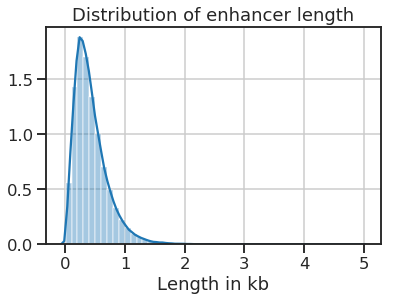

In [19]:
lens = df_enhs.loc[shared_enhs, 'length']
fig, ax = plt.subplots()
sns.distplot(lens.values/1000, ax=ax)
ax.set_xlabel('Length in kb')
ax.set_title('Distribution of enhancer length')
output_name = 'Enhancer length distribution' 
fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
plt.show()


In [20]:
# full correlation

# gene 
_x_features = shared_genes 
_X = gene_rna_clsts.values
# # enhancer
_y_features = shared_enhs
_Y = enh_mcg_clsts.values 
print(_X.shape, _Y.shape)

# row genes_list 
def get_tss(row):
    if row['strand'] == '+':
        return row['start']
    elif row['strand'] == '-':
        return row['end']
genes_list = df_genes.set_index('gid').reindex(shared_genes).reset_index().copy()
genes_list['chrom'] = genes_list['chr'].apply(lambda x: x[len('chr'):])
genes_list['tss'] = genes_list.apply(get_tss, axis=1)

# row ens_list
ens_list = df_enhs.set_index('index').loc[shared_enhs].reset_index()
ens_list['center'] = ens_list[['start', 'end']].mean(axis=1).astype(int)

print(ens_list.shape, genes_list.shape)
genes_list.head()

(21482, 28) (171891, 28)
(171891, 8) (21482, 11)


,gid,gene_id,gene_name,chr,start,end,strand,gene_type,chrom,length,tss
0,ENSMUSG00000000001,ENSMUSG00000000001.4,Gnai3,chr3,108107280,108146146,-,protein_coding,3,38866,108146146
1,ENSMUSG00000000003,ENSMUSG00000000003.15,Pbsn,chrX,77837901,77853623,-,protein_coding,X,15722,77853623
2,ENSMUSG00000000028,ENSMUSG00000000028.14,Cdc45,chr16,18780447,18811987,-,protein_coding,16,31540,18811987
3,ENSMUSG00000000037,ENSMUSG00000000037.16,Scml2,chrX,161117193,161258213,+,protein_coding,X,141020,161117193
4,ENSMUSG00000000049,ENSMUSG00000000049.11,Apoh,chr11,108343354,108414396,+,protein_coding,11,71042,108343354


In [21]:
# more than 15 mins for ~500,000 enhancers

# tss and enhancer center: 500KB ~ 2KB
# to_evals - ens, gene, val, dist

_X_ranks = snmcseq_utils.rank_rows(_X)
_Y_ranks = snmcseq_utils.rank_rows(_Y)

KB = 1000
window_size = 2000*KB # (+/- 1Mb)
inner_window_size = 4*KB #(+/- 2kb)
to_evals = [] 

ti = time.time()
# ens, gene
for idx, gene in genes_list.iterrows():
    if idx % 1000 == 0:
        print(idx, time.time()-ti)
    
    chrom, pos = gene['chrom'], gene['tss']
    if chrom in ['Y']:
        continue
    chrom_size = snmcseq_utils.get_chrom_lengths_mouse().loc[chrom]
    window = [max(0, pos-window_size/2), 
              min(chrom_size, pos+window_size/2)]
    window_exclude = [max(0, pos-inner_window_size/2),
                      min(chrom_size, pos+inner_window_size/2)
                     ]

    # get ens
    pos_enh = ens_list['center'] 
    cond = ((ens_list['chrom'] == chrom) 
             & (pos_enh >= window[0]) 
             & (pos_enh <= window[1])
             & ((pos_enh <= window_exclude[0]) | (pos_enh >= window_exclude[1]))
            )
    ens_include = [ens for ens in ens_list[cond]['index'].values if ens in _y_features]
    for ens in ens_include:
        to_evals.append((gene['gid'], ens))
to_evals = pd.DataFrame(to_evals, columns=['gene', 'ens'])

output_toevals = output_results.format('to_evals.tsv')
print(to_evals.shape)
to_evals.head()
to_evals.to_csv(output_toevals, sep="\t", header=True, index=False)

0 0.0060079097747802734


/cndd/fangming/CEMBA/snmcseq_dev/snmcseq_utils.py:461: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  srs_gsize = pd.read_table(genome_size_fname, header=None, index_col=0, squeeze=True)


1000 35.11996865272522
2000 71.187833070755
3000 109.68912839889526
4000 147.44612383842468
5000 184.1503620147705
6000 221.41207265853882
7000 259.3791422843933
8000 294.6383237838745
9000 330.697829246521
10000 367.3382158279419
11000 404.4376952648163
12000 441.76889157295227
13000 477.970636844635
14000 515.116170167923
15000 550.2481427192688
16000 584.3537290096283
17000 620.1225099563599
18000 656.9136397838593
19000 691.7912607192993
20000 731.246871471405
21000 768.1205008029938
(3158769, 2)


In [22]:
f = output_results.format('to_evals.tsv')
to_evals = pd.read_csv(f, sep="\t")
print(to_evals.shape)
to_evals.head()

(3158769, 2)


,gene,ens
0,ENSMUSG00000000001,33736
1,ENSMUSG00000000001,33737
2,ENSMUSG00000000001,33739
3,ENSMUSG00000000001,33740
4,ENSMUSG00000000001,33741


In [23]:
ti = time.time()
# val, dist
_x_idx = snmcseq_utils.get_index_from_array(_x_features, to_evals['gene'].values)
_y_idx = snmcseq_utils.get_index_from_array(_y_features, to_evals['ens'].values)
to_evals['val'] = snmcseq_utils.vcorrcoef(_X_ranks[_x_idx], _Y_ranks[_y_idx]) 
to_evals['dist'] = np.abs(ens_list.set_index('index').loc[to_evals['ens'].values, 'center'].values 
                        - genes_list.set_index('gid').loc[to_evals['gene'].values, 'tss'].values 
                        )

print(time.time()-ti)
to_evals.head()

33.154125690460205


,gene,ens,val,dist
0,ENSMUSG00000000001,33736,-0.319650,995118
1,ENSMUSG00000000001,33737,-0.260536,991637
2,ENSMUSG00000000001,33739,-0.438424,987167
3,ENSMUSG00000000001,33740,0.076081,985899
4,ENSMUSG00000000001,33741,-0.129174,983725


In [24]:
# shuffle

ti = time.time()
np.random.seed(0)

to_evals_shuffled = [] 
# shuffle gene_name label
genes_list_shuffle = genes_list.copy()
# genes_list_shuffle['gene_name'] = np.random.permutation(genes_list_shuffle['gene_name'].values)
genes_list_shuffle['gid'] = np.random.permutation(genes_list_shuffle['gid'].values)

# ens, gene
for idx, gene in genes_list_shuffle.iterrows():
    if idx % 1000 == 0:
        print(idx, time.time()-ti)
    
    chrom, pos = gene['chrom'], gene['tss']
    if chrom in ['Y']:
        continue
    chrom_size = snmcseq_utils.get_chrom_lengths_mouse().loc[chrom]
    window = [max(0, pos-window_size/2), 
              min(chrom_size, pos+window_size/2)]
    window_exclude = [max(0, pos-inner_window_size/2),
                      min(chrom_size, pos+inner_window_size/2)
                     ]

    # get ens
    pos_enh = ens_list['center'] 
    cond = ((ens_list['chrom'] == chrom) 
             & (pos_enh >= window[0]) 
             & (pos_enh <= window[1])
             & ((pos_enh <= window_exclude[0]) | (pos_enh >= window_exclude[1]))
            )
    ens_include = [ens for ens in ens_list[cond]['index'].values if ens in _y_features]
    for ens in ens_include:
        to_evals_shuffled.append((gene['gid'], ens))
to_evals_shuffled = pd.DataFrame(to_evals_shuffled, columns=['gene', 'ens'])

print(len(to_evals_shuffled))

f = output_results.format('to_evals_shuffled.tsv')
print(to_evals_shuffled.shape)
to_evals_shuffled.to_csv(f, sep="\t", header=True, index=False)
to_evals_shuffled.head()

0 0.012682437896728516


/cndd/fangming/CEMBA/snmcseq_dev/snmcseq_utils.py:461: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  srs_gsize = pd.read_table(genome_size_fname, header=None, index_col=0, squeeze=True)


1000 34.882805824279785
2000 69.7245454788208
3000 107.82404661178589
4000 148.27117800712585
5000 183.59112811088562
6000 221.0054361820221
7000 258.78876757621765
8000 294.1773638725281
9000 331.40865111351013
10000 366.81605315208435
11000 401.1632397174835
12000 452.76099586486816
13000 493.8586003780365
14000 531.4027407169342
15000 578.2127072811127
16000 625.8352723121643
17000 661.0483713150024
18000 699.4438688755035
19000 746.1506373882294
20000 786.0568993091583
21000 824.7289497852325
3158769
(3158769, 2)


,gene,ens
0,ENSMUSG00000041360,33736
1,ENSMUSG00000041360,33737
2,ENSMUSG00000041360,33739
3,ENSMUSG00000041360,33740
4,ENSMUSG00000041360,33741


In [25]:
f = output_results.format('to_evals_shuffled.tsv')
to_evals_shuffled = pd.read_csv(f, sep="\t")
print(to_evals_shuffled.shape)
to_evals_shuffled.head()

(3158769, 2)


,gene,ens
0,ENSMUSG00000041360,33736
1,ENSMUSG00000041360,33737
2,ENSMUSG00000041360,33739
3,ENSMUSG00000041360,33740
4,ENSMUSG00000041360,33741


In [26]:
ti = time.time()
# val, dist
_x_idx = snmcseq_utils.get_index_from_array(_x_features, to_evals_shuffled['gene'].values)
_y_idx = snmcseq_utils.get_index_from_array(_y_features, to_evals_shuffled['ens'].values)
to_evals_shuffled['val'] = snmcseq_utils.vcorrcoef(_X_ranks[_x_idx], _Y_ranks[_y_idx]) 
to_evals_shuffled['dist'] = np.abs(ens_list.set_index('index').loc[to_evals_shuffled['ens'].values, 'center'].values 
                        - genes_list_shuffle.set_index('gid').loc[to_evals_shuffled['gene'].values, 'tss'].values 
                        )

print(time.time()-ti)
to_evals_shuffled.head()

31.962195873260498


,gene,ens,val,dist
0,ENSMUSG00000041360,33736,-0.152162,995118
1,ENSMUSG00000041360,33737,0.108922,991637
2,ENSMUSG00000041360,33739,0.070608,987167
3,ENSMUSG00000041360,33740,-0.329502,985899
4,ENSMUSG00000041360,33741,-0.227148,983725


In [27]:
# mean within a distance bin
n = 100
_dist = np.linspace(0, window_size/(2*KB), n)
_tmp = to_evals.join(pd.qcut(to_evals['dist'], n, labels=False).to_frame('qcut')).groupby('qcut')['val']
_mval = _tmp.mean()
_stdval = _tmp.std()
_sizes = _tmp.size()
print(_dist.shape, _mval.shape)

(100,) (100,)


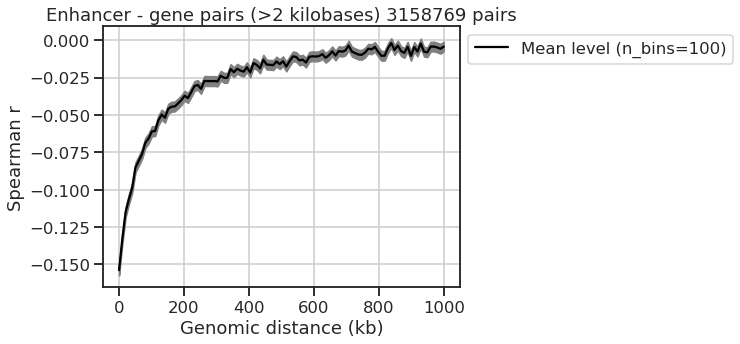

In [28]:
scale = 0.8
fig, ax = plt.subplots(figsize=(8*scale,6*scale))
x = to_evals['dist'].values/1000, 
y = to_evals['val'].values, 

yerr = 1.96*_stdval/np.sqrt(_sizes)
ax.plot(
    _dist, _mval,
    # yerr=yerr,
    '-',
    c='black',
    label='Mean level (n_bins={})'.format(n),
    markersize=5,
    # capsize=3,
)

ax.fill_between(_dist, _mval-yerr, _mval+yerr, color='gray')
ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel('Genomic distance (kb)')
ax.set_ylabel('Spearman r')
ax.set_title('Enhancer - gene pairs (>2 kilobases) {} pairs'.format(len(to_evals)))
output_name = 'line_distance_vs_spearmanr' 
fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
plt.show()
    


### Statistical evaluation 
compute local FDR: 
- histogram -> density estimation (interpolate) -> cdf (cumsum), ratio of cdf
- quantile ranking (cdf) -> interpolate -> ratio of cdf

#### Setting up 

In [29]:
def bin_mean(x, y, bins):
    """Bin x according to bins, return bins, y_mean
    """
    # bin _x and mean_y
    _df = pd.DataFrame()
    _df['bin'] = np.digitize(_x, bins)
    _df['_y'] = _y
    _y_mean = _df.groupby('bin').mean()['_y']
    
    return bins[_y_mean.index], _y_mean.values

def fdr(x, x_bck, y_bck, x_fr, y_fr):
    """
    """
    return (np.interp(x, x_bck, y_bck))/(np.interp(x, x_fr, y_fr)+1e-6)

def pvalue(x, x_bck, y_bck):
    """
    """
    return np.interp(x, x_bck, y_bck)


In [30]:
regions = df_enhs # back compatibility

In [31]:
# randomly sample many genes and enhancers
ti = time.time()

p = 0.05
np.random.seed(0)
_y_selected_idx = np.arange(len(_y_features))[np.random.rand(len(_y_features))<p]
_x_selected_idx = np.arange(len(_x_features))

_x_selected_features = _x_features[_x_selected_idx]
_y_selected_features = _y_features[_y_selected_idx]

# same chrom or not
x_chroms = df_genes.set_index('gid').reindex(_x_selected_features)['chrom'].values
y_chroms = regions.set_index('index').reindex(_y_selected_features)['chrom'].values

corr = snmcseq_utils.spearman_corrcoef(_X[_x_selected_idx], _Y[_y_selected_idx])[:len(_x_selected_idx), len(_x_selected_idx):]
corr_cis_mask = np.zeros_like(corr)
for i, x_chrom in enumerate(x_chroms):
    for j, y_chrom in enumerate(y_chroms):
        if x_chrom == y_chrom:
            corr_cis_mask[i,j] = 1
            
corr_cis = corr[corr_cis_mask.nonzero()]
# corr_noncis = corr[(~corr_cis_mask.astype(bool)).nonzero()] 
print(time.time()-ti)

97.57358598709106


In [32]:
labels = ['All',
          'Same chrom',
        '<500kb',
        '<200kb',
        '<100kb',
        '<100kb shuffled',
         ]

corr_tracks = [corr.flatten(),
       corr_cis,
       to_evals.loc[to_evals['dist']<=500*KB, 'val'].values,
       to_evals.loc[to_evals['dist']<=200*KB, 'val'].values,
       to_evals.loc[to_evals['dist']<=100*KB, 'val'].values,
       to_evals_shuffled.loc[to_evals_shuffled['dist']<=100*KB, 'val'].values,
      ]

subsample_rates = [0.01,
                  0.1,
                  1,
                  1,
                  1,
                  1,
                 ]

np.random.seed(0)
corr_tracks = [corr_tracks[i][np.random.rand(len(corr_tracks[i])) < subsample_rates[i]] 
               for i in range(len(corr_tracks))]

colors = ['black', 'gray', 'C0', 'C2', 'C1', 'C7']

In [33]:
# FDR

bins = np.linspace(-1, 1, 200)
bins_eval = np.linspace(-1, 1, 2000)

# background
_x = np.sort(corr_tracks[0])
_y = np.arange(len(_x))/len(_x)
x_smooth_bck, y_smooth_bck = bin_mean(_x, _y, bins)
# pvalue
pvalues = pvalue(bins_eval, x_smooth_bck, y_smooth_bck)
to_evals['pvalues'] = pvalue(to_evals['val'].values, x_smooth_bck, y_smooth_bck)

# fore-ground - 2
fdrs = []
for corr_track, track_name in zip(corr_tracks[2:5], labels[2:5]):
    _x = np.sort(corr_track)
    _y = np.arange(len(_x))/len(_x)
    x_smooth_fr0, y_smooth_fr0 = bin_mean(_x, _y, bins)
    # ratio 2
    fdrs.append(fdr(bins_eval, x_smooth_bck, y_smooth_bck, x_smooth_fr0, y_smooth_fr0))
    to_evals['fdr{}'.format(track_name)] = fdr(to_evals['val'].values, x_smooth_bck, y_smooth_bck, x_smooth_fr0, y_smooth_fr0)

In [34]:
to_evals.head()

,gene,ens,val,dist,pvalues,fdr<500kb,fdr<200kb,fdr<100kb
0,ENSMUSG00000000001,33736,-0.319650,995118,0.141100,0.745977,0.628894,0.555073
1,ENSMUSG00000000001,33737,-0.260536,991637,0.188823,0.775521,0.669092,0.601101
2,ENSMUSG00000000001,33739,-0.438424,987167,0.069513,0.678363,0.543472,0.462255
3,ENSMUSG00000000001,33740,0.076081,985899,0.587249,0.917335,0.870413,0.837334
4,ENSMUSG00000000001,33741,-0.129174,983725,0.324578,0.836429,0.754420,0.698684


In [35]:
### vary FDR
_tracks = collections.OrderedDict({
    '2-100': to_evals.loc[((to_evals['dist']>2*KB) & 
                        (to_evals['dist']<=100*KB)), 'val'].values,
    '100-200': to_evals.loc[((to_evals['dist']>100*KB) & 
                        (to_evals['dist']<=200*KB)), 'val'].values,
    '200-300': to_evals.loc[((to_evals['dist']>200*KB) & 
                        (to_evals['dist']<=300*KB)), 'val'].values,
    '300-400': to_evals.loc[((to_evals['dist']>300*KB) & 
                        (to_evals['dist']<=400*KB)), 'val'].values,
    '400-500': to_evals.loc[((to_evals['dist']>400*KB) & 
                        (to_evals['dist']<=500*KB)), 'val'].values,
})

res_num_sig = []
for track_name, corr_track in _tracks.items():
    _x = np.sort(corr_track)
    _y = np.arange(len(_x))/len(_x)
    x_smooth_fr, y_smooth_fr = bin_mean(_x, _y, bins)
    fdr_new = fdr(corr_track, x_smooth_bck, y_smooth_bck, x_smooth_fr, y_smooth_fr)
    num_sig = np.sum(fdr_new < 0.20)
    res_num_sig.append({'track_name': track_name, 
                        'num_sig': num_sig,
                       })
    
res_num_sig = pd.DataFrame(res_num_sig)
print(res_num_sig.shape)
res_num_sig.head()

(5, 2)


,num_sig,track_name
0,3705,2-100
1,28,100-200
2,7,200-300
3,0,300-400
4,3,400-500


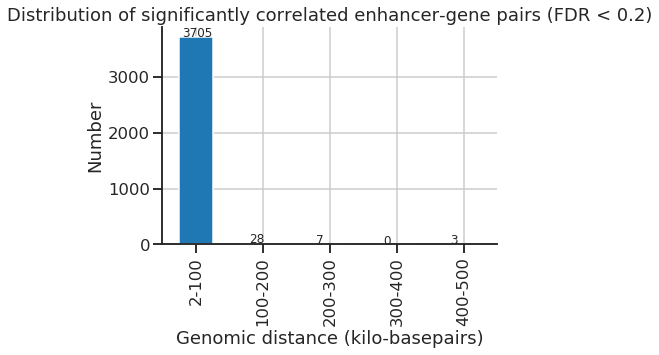

In [36]:
output_name = 'FDR_number'
fig, ax = plt.subplots()
res_num_sig.plot.bar(ax=ax, legend=False)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()+0.05, p.get_height() * 1.005), fontsize=12)
ax.set_ylabel('Number')
sns.despine(ax=ax)
ax.set_title('Distribution of significantly correlated enhancer-gene pairs (FDR < 0.2)')
ax.set_xticklabels(res_num_sig['track_name'].values)
ax.set_xlabel('Genomic distance (kilo-basepairs)')
fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
plt.show()

#### Test individual pairs

In [37]:
to_evals.head()

,gene,ens,val,dist,pvalues,fdr<500kb,fdr<200kb,fdr<100kb
0,ENSMUSG00000000001,33736,-0.319650,995118,0.141100,0.745977,0.628894,0.555073
1,ENSMUSG00000000001,33737,-0.260536,991637,0.188823,0.775521,0.669092,0.601101
2,ENSMUSG00000000001,33739,-0.438424,987167,0.069513,0.678363,0.543472,0.462255
3,ENSMUSG00000000001,33740,0.076081,985899,0.587249,0.917335,0.870413,0.837334
4,ENSMUSG00000000001,33741,-0.129174,983725,0.324578,0.836429,0.754420,0.698684


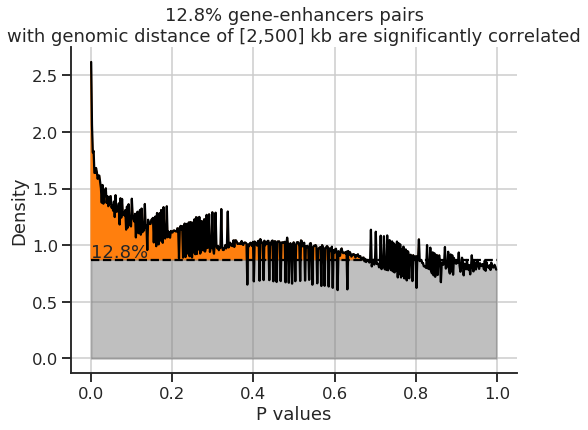

In [38]:
# plot pvalues
output_name = 'fraction-of-h1-one-example'

y = to_evals.loc[to_evals['dist']<500*KB, 'pvalues'].sort_values().values
bin_n = 500
bin_edges = np.linspace(0, 1, bin_n)
bin_width = 1.0/bin_n
bin_counts, bin_edges = np.histogram(y, bin_edges)
y_norm = bin_counts/(bin_width*bin_counts.sum())
null_level = y_norm[-int(0.50*bin_n):].mean()
# frac_tp = np.sum(np.maximum(y_norm-null_level, 0)*bin_width)
frac_tp = 1 - null_level 


fig, ax = plt.subplots(figsize=(8,6))
ax.plot(bin_edges[:-1], y_norm, color='k')
ax.plot([0, 1], [null_level]*2, linestyle='--', color='k')
ax.fill_between(bin_edges[:-1], null_level, y_norm, 
                where=y_norm>null_level, alpha=1, color='C1')
ax.fill_between(bin_edges[:-1], 0, np.minimum(y_norm, null_level), alpha=0.5, color='grey')
ax.text(0, null_level+0.2*(1-null_level), 
        "{:.1f}%".format(frac_tp*100), 
        fontsize=18)
sns.despine(ax=ax)


ax.set_xlabel('P values')
ax.set_ylabel('Density')
ax.set_title("{:.1f}% gene-enhancers pairs\nwith genomic distance of [2,500] kb are significantly correlated".format(frac_tp*100))
fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
plt.show()

In [39]:
frac_tps = []
num_tps = []
dists_kb = np.hstack([[10, 20, 50], np.arange(100, 1000+1, 100)]) 

for idx in np.arange(len(dists_kb)):
    dist_kb = dists_kb[idx]
    if idx == 0:
        cond = (to_evals['dist'] < dist_kb*KB)
    else:
        dist_kb_prev = dists_kb[idx-1]
        cond = ((to_evals['dist'] < dist_kb*KB) & 
                (to_evals['dist'] >= dist_kb_prev*KB))
    
    y = to_evals.loc[cond, 'pvalues'].values
    bin_n = 500
    bin_edges = np.linspace(0, 1, bin_n)
    bin_width = 1.0/bin_n
    bin_counts, bin_edges = np.histogram(y, bin_edges)
    y_norm = bin_counts/(bin_width*bin_counts.sum())
    null_level = y_norm[-int(0.50*bin_n):].mean()
    frac_tp = 1 - null_level 
    frac_tps.append(frac_tp)
    num_tps.append(len(y))


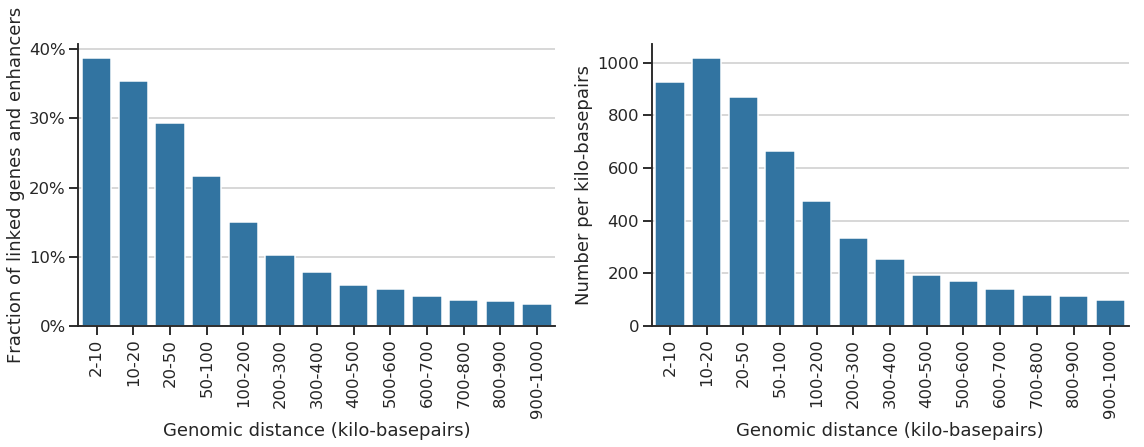

In [40]:
output_name = 'fraction-of-h1-summary'

df_plot = pd.DataFrame(np.vstack([dists_kb, frac_tps]).T, columns=['x', 'y'])
dists_kb_plot = np.hstack([[2], dists_kb])
df_plot['x_formatted'] = ["{}-{}".format(dists_kb_plot[i], dists_kb_plot[i+1]) for i in range(len(dists_kb))]
df_plot['length'] = [dists_kb_plot[i+1] - dists_kb_plot[i] for i in range(len(dists_kb))]
df_plot['num'] = np.array(num_tps)*np.array(frac_tps)
df_plot['num_norm'] = df_plot['num']/df_plot['length']

fig, axs = plt.subplots(1, 2, figsize=(8*2,6), sharex=True)
ax = axs[0]
sns.barplot(x='x_formatted', y='y', data=df_plot, color='C0', ax=ax)
ax.set_xlabel('Genomic distance (kilo-basepairs)')
ax.set_ylabel('Fraction of linked genes and enhancers')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(PercentFormat) 
sns.despine(ax=ax)

ax = axs[1]
sns.barplot(x='x_formatted', y='num_norm', data=df_plot, color='C0', ax=ax)
ax.set_xlabel('Genomic distance (kilo-basepairs)')
ax.set_ylabel('Number per kilo-basepairs')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
sns.despine(ax=ax)

fig.tight_layout()
fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
plt.show()



In [41]:
# significant ones
sig_cond = (
    ((to_evals['fdr<100kb']<0.05) & (to_evals['dist']<100*KB)) |
    ((to_evals['fdr<200kb']<0.05) & (to_evals['dist']<200*KB)) |
    ((to_evals['fdr<500kb']<0.05) & (to_evals['dist']<500*KB))
)

top_sig = to_evals[sig_cond].sort_values(['val']) #.head(30)
top_sig['gene_name'] = gid_to_name.loc[top_sig['gene'].values].values

# top_sig = to_evals[(to_evals['fdr-200k']<0.05) & (to_evals['dist']<200*KB)].sort_values(['fdr-200k', 'val']) #.head(30)
# top_sig = to_evals[(to_evals['fdr-500k']<0.05) & (to_evals['dist']<500*KB)].sort_values(['fdr-100k', 'val']) #.head(30)

top_sig = pd.merge(top_sig, ens_list, left_on='ens', right_on='index')
top_sig_genes = top_sig.groupby('gene').size().sort_values(ascending=False).index.values
top_sig_ens = top_sig.groupby('ens').size().sort_values(ascending=False).index.values

n_pair, n_enh, n_gene = len(top_sig), len(top_sig_ens), len(top_sig_genes)
print('{} significantly correlated enhancer-gene pairs\n{}/{} enhancers {}/{} genes'
    .format(n_pair, n_enh, len(_y_features), n_gene, len(_x_features)) 
     )
top_sig.head()

188 significantly correlated enhancer-gene pairs
183/171891 enhancers 128/21482 genes


,gene,ens,val,dist,pvalues,fdr<500kb,fdr<200kb,fdr<100kb,gene_name,index,chr,start,end,clsts,length,chrom,center
0,ENSMUSG00000014164,130150,-0.928845,40560,5.446448e-07,0.144229,0.078369,0.040455,Klhl3,130150,chr13,58072362,58073703,"2-1,2-2,2-3,3-1,3-2,4-1,4-2",1341,13,58073032
1,ENSMUSG00000001911,83604,-0.926656,33953,5.446448e-07,0.135573,0.072747,0.037335,Nfix,83604,chr8,84763913,84768870,"1-1,1-2,2-2,3-1,4-1,4-2",4957,8,84766391
2,ENSMUSG00000044216,148649,-0.926108,3044,5.446448e-07,0.133569,0.071466,0.036629,Kcnj4,148649,chr15,79501161,79503233,"1-1,1-2,2-1,2-2,2-3,3-1,3-2,4-1,4-2,9-1",2072,15,79502197
3,ENSMUSG00000057880,151686,-0.920088,11877,5.446448e-07,0.114888,0.059864,0.030320,Abat,151686,chr16,8524079,8526533,"5-1,5-2,5-3,6-1,6-2,6-4,6-5",2454,16,8525306
4,ENSMUSG00000043811,152367,-0.920088,17325,5.446448e-07,0.114888,0.059864,0.030320,Rtn4r,152367,chr16,18143879,18146055,"1-1,1-2,2-1,2-3,3-1,3-2,4-1,4-2",2176,16,18144967


#### Plots 

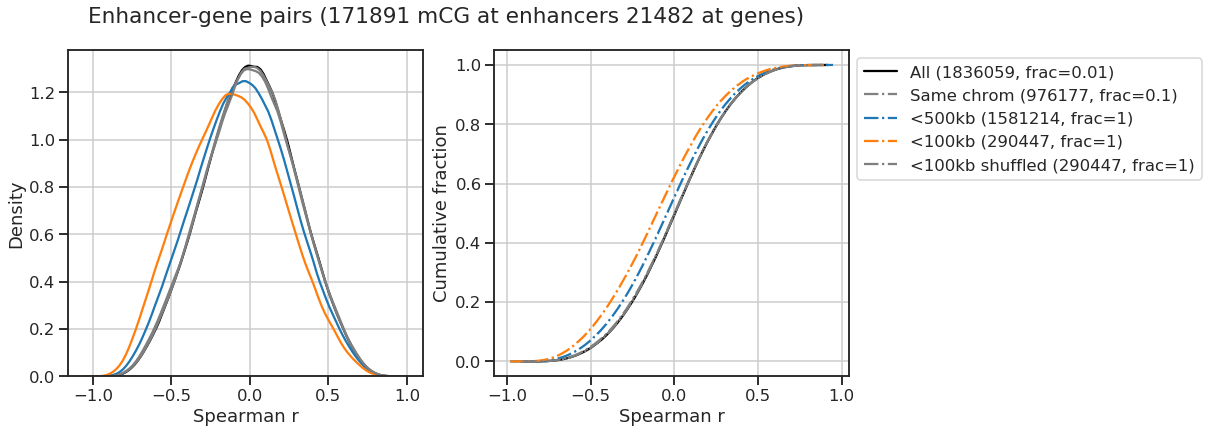

In [42]:
with sns.plotting_context('talk'):
    fig, axs = plt.subplots(1, 2, figsize=(7*2,6))
    ax = axs[0]
    for _x, label, color in zip(corr_tracks, labels, colors):
        if label == '<200kb':
            continue
        sns.distplot(np.sort(_x), ax=ax, 
#                      label='{} ({})'.format(label, len(_x)),
                     color=color,
                     hist=False,
                    )

    ax.set_xlabel('Spearman r')
    ax.set_ylabel('Density')
    
    ax = axs[1]
    for _x, label, color, subsample_rate in zip(corr_tracks, labels, colors, subsample_rates):
        if label == '<200kb':
            continue
            
        linestyle = '-.'
        if label == 'All':
            linestyle = '-'
        ax.plot(np.sort(_x), np.arange(len(_x))/len(_x), 
                linestyle,
                label='{} ({}, frac={})'.format(label, len(_x), subsample_rate),
                color=color,
               )

    ax.legend(bbox_to_anchor=(1,1))
    ax.set_xlabel('Spearman r')
    ax.set_ylabel('Cumulative fraction')
    
    fig.suptitle('Enhancer-gene pairs ({} mCG at enhancers {} at genes)'.format(len(_y_features), len(_x_features)), 
                )
    
    output_name = 'distribution-different-categories' 
    fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
#     fig.tight_layout()
    plt.show()

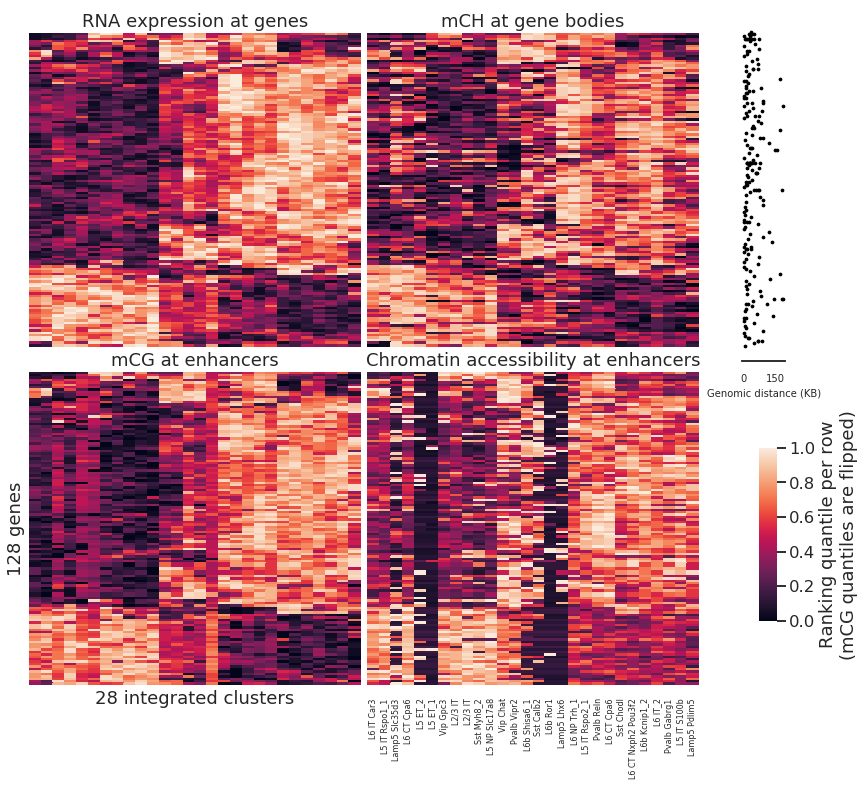

In [43]:
# heatmap of gene by cluster
# set_matplotlib_formats('pdf')

# back compactibility
clusters_selected = shared_clusters
clusters_selected_labels = np.array([clst_annot.loc[clst] for clst in clst_annot.index.values])

def zscore(x):
    return (x - np.mean(x))/np.std(x)

cmap = 'rocket'

# rna at genes 
rna_mat = gene_rna_clsts.loc[top_sig_genes, clusters_selected]
rna_mat_norm = rna_mat.rank(pct=True, axis=1) #.apply(zscore, axis=1)

# row gene
Z = sch.linkage(rna_mat_norm, method='average', metric='euclidean', optimal_ordering=True)
dn = sch.dendrogram(Z, no_plot=True)

# col clst
Z = sch.linkage(rna_mat_norm.T, method='average', metric='euclidean', optimal_ordering=True)
dn_clst = sch.dendrogram(Z, no_plot=True)

# 
genes_ordered = rna_mat_norm.index.values[dn['leaves']]
ens_ordered = top_sig.set_index('gene').loc[genes_ordered]

# mCH at genes
mch_mat = gene_mch_clsts.reindex(genes_ordered).loc[:, clusters_selected]

# mC at enhancers 
mcc_mat = enh_mcg_clsts.loc[ens_ordered['ens'].values, clusters_selected] 
mcc_mat['gene'] = ens_ordered.index.values
mcc_mat = mcc_mat.groupby('gene').mean().loc[genes_ordered]

# ATAC at enhancers
atac_mat = enh_atac_clsts.loc[ens_ordered['ens'].values, clusters_selected] 
atac_mat['gene'] = ens_ordered.index.values
atac_mat = atac_mat.groupby('gene').mean().loc[genes_ordered]
    
with sns.plotting_context('talk'), sns.axes_style('white'):
    fig, axs = plt.subplots(2, 2, figsize=(6*2,6*2))
    cbar_ax = fig.add_axes([.97, .2, .02, .2])
    
    # distance panel
    dist_ax = fig.add_axes([.95, .5, .05, .4])
    ax = dist_ax
    
    dists = top_sig.set_index('gene').loc[genes_ordered,  'dist']/KB
    genes_idx = snmcseq_utils.get_index_from_array(genes_ordered, dists.index.values)
    
    ax.scatter(dists.values, genes_idx, s=5, c='black')
    ax.invert_yaxis()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticklabels([])
    
    ax.xaxis.set_major_locator(plt.MaxNLocator(2))
    ax.xaxis.set_tick_params(labelsize=10)
    ax.set_xlabel('Genomic distance (KB)', fontsize=10)
    
    
    ax = axs[0,0]
    g = sns.heatmap(rna_mat_norm.iloc[dn['leaves'], dn_clst['leaves']],
#                     xticklabels=clusters_selected_labels[dn_clst['leaves']], 
                    xticklabels=False,
                    yticklabels=False,
                    cbar=False,
                    vmin=0, vmax=1,
                    ax=ax,
                    cmap=cmap,
                   )
    ax.set_title('RNA expression at genes')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    ax = axs[1,0]
    g = sns.heatmap((1-mcc_mat.rank(axis=1, pct=True)).iloc[:, dn_clst['leaves']], #, #.apply(zscore, axis=1), 
                    yticklabels=False,
                    # xticklabels=clusters_selected_labels[dn_clst['leaves']], 
                    xticklabels=False,
                    vmin=0, vmax=1,
                    cbar_ax=cbar_ax,
                    cbar_kws={'fraction': 0.05, 
                              'label': 'Ranking quantile per row\n(mCG quantiles are flipped)',
                             }, 
                    cmap=cmap,
                    ax=ax)
    ax.set_title('mCG at enhancers')
    ax.set_xlabel('{} integrated clusters'.format(len(dn_clst['leaves'])))
    ax.set_ylabel('{} genes'.format(len(dn['leaves'])))
    
    ax = axs[0,1]
    g = sns.heatmap((1-mch_mat.rank(axis=1, pct=True)).iloc[:, dn_clst['leaves']], #, #.apply(zscore, axis=1), 
                    yticklabels=False,
                    xticklabels=False, 
                    vmin=0, vmax=1,
                    cbar=False,
                    cmap=cmap,
                    ax=ax)
    
    ax.set_title('mCH at gene bodies')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    ax = axs[1,1]
    g = sns.heatmap(atac_mat.rank(axis=1, pct=True).iloc[:, dn_clst['leaves']], #, #.apply(zscore, axis=1), 
                    yticklabels=False,
                    xticklabels=clusters_selected_labels[dn_clst['leaves']], 
                    vmin=0, vmax=1,
                    cbar=False,
                    cmap=cmap,
                    ax=ax)
    
    ax.set_title('Chromatin accessibility at enhancers')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
    ax.set_ylabel('')
    ax.set_xlabel('')
    fig.subplots_adjust(wspace=0.02, hspace=0.08)
    
#     fig.tight_layout()
    output_name = 'heatmap-example-enhancer-genes' 
    fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
    plt.show()

### Compare with nearest gene 

In [44]:
# get nn gene information
top_sig['nearest_gene'] = regions_info.set_index('index').loc[top_sig['ens'].values, 'gene_name'].values

n_nngenes = (top_sig['gene'] == top_sig['nearest_gene']).sum()
print("{}/{}={:.2f} pairs are from the nearest genes, {} non-trivial pairs"
      .format(n_nngenes, n_pair, n_nngenes/n_pair, n_pair-n_nngenes))
    
nontr_top_sig = top_sig.loc[(top_sig['gene'] != top_sig['nearest_gene'])].sort_values('dist', ascending=False)
print(nontr_top_sig.shape)
nontr_top_sig.head()

0/188=0.00 pairs are from the nearest genes, 188 non-trivial pairs
(188, 18)


,gene,ens,val,dist,pvalues,fdr<500kb,fdr<200kb,fdr<100kb,gene_name,index,chr,start,end,clsts,length,chrom,center,nearest_gene
36,ENSMUSG00000053519,109275,-0.897646,187175,2.085346e-06,0.076330,0.039004,0.020679,Kcnip1,109275,chr11,33805461,33806493,6-5,1032,11,33805977,Kcnip1-202
22,ENSMUSG00000106515,37114,-0.905857,186813,9.447068e-07,0.059176,0.029858,0.015078,Gm30382,37114,chr3,149258066,149258910,"1-1,1-2,2-3,3-2,4-1,4-2",844,3,149258488,Gm10287-201
76,ENSMUSG00000053519,109276,-0.887247,182756,4.979163e-06,0.099624,0.049152,0.027686,Kcnip1,109276,chr11,33810190,33810602,"5-1,5-3,6-2",412,11,33810396,Kcnip1-202
70,ENSMUSG00000056708,9727,-0.888342,181680,4.534235e-06,0.097437,0.048488,0.027136,Ier5,9727,chr1,155281150,155281483,"1-1,1-2,2-1,2-2,2-3,3-1,3-2,4-1,4-2",333,1,155281316,Xpr1-207
17,ENSMUSG00000049556,91632,-0.909141,173348,5.887649e-07,0.049333,0.024409,0.011978,Lingo1,91632,chr9,56622734,56623506,"1-1,3-1,4-1",772,9,56623120,Lingo1-203


In [45]:
# nontr_top_sig.groupby('gene').size().sort_values(ascending=False)

In [46]:
# browser link
for j, (i, row) in enumerate(nontr_top_sig.iterrows()):
    if j > 30:
        break
    print(row['gene'], snmcseq_utils.gen_annoj_url(row['chrom'], row['center'], 30, file='index_Ens100_Fangming.html'))


ENSMUSG00000053519 https://brainome.ucsd.edu/annoj_private/CEMBA/index_Ens100_Fangming.html?assembly=11&position=33805977&bases=30
ENSMUSG00000106515 https://brainome.ucsd.edu/annoj_private/CEMBA/index_Ens100_Fangming.html?assembly=3&position=149258488&bases=30
ENSMUSG00000053519 https://brainome.ucsd.edu/annoj_private/CEMBA/index_Ens100_Fangming.html?assembly=11&position=33810396&bases=30
ENSMUSG00000056708 https://brainome.ucsd.edu/annoj_private/CEMBA/index_Ens100_Fangming.html?assembly=1&position=155281316&bases=30
ENSMUSG00000049556 https://brainome.ucsd.edu/annoj_private/CEMBA/index_Ens100_Fangming.html?assembly=9&position=56623120&bases=30
ENSMUSG00000108141 https://brainome.ucsd.edu/annoj_private/CEMBA/index_Ens100_Fangming.html?assembly=6&position=115291864&bases=30
ENSMUSG00000022044 https://brainome.ucsd.edu/annoj_private/CEMBA/index_Ens100_Fangming.html?assembly=14&position=66516592&bases=30
ENSMUSG00000028086 https://brainome.ucsd.edu/annoj_private/CEMBA/index_Ens100_Fangmi

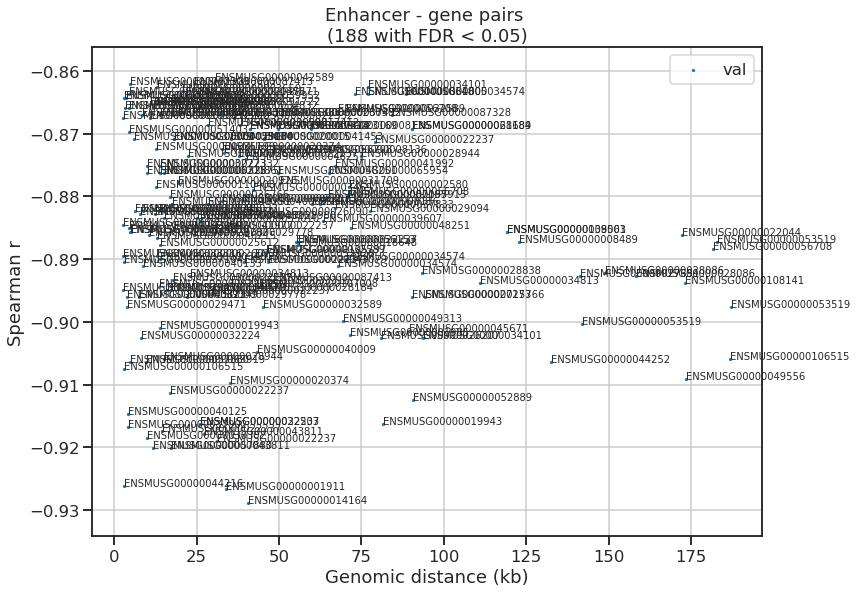

In [47]:
# vals 
scale = 1.5
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(8*scale,6*scale))
        
#     # plot mean
#     ax.plot(
#         _dist, _mval,
#         c='gray',
#         label='Mean level (n_bins={})'.format(n),
#     )
    
    # plot significant 
    _df = nontr_top_sig 
    ax.scatter(_df['dist']/1000, _df['val'], s=3)
        
    # plot significant 
    _df = nontr_top_sig 
    texts = []
    for idx, row in _df.iterrows():
        texts.append(
            ax.text(
                row['dist']/1000, 
                row['val'], 
                "{}".format(row['gene']),
                fontsize=10,
        ))
#     adjust_text(texts) 
    
    ax.legend(bbox_to_anchor=(1, 1))
    ax.set_xlabel('Genomic distance (kb)')
    ax.set_ylabel('Spearman r')
    ax.set_title('Enhancer - gene pairs \n({} with FDR < 0.05)'.format(len(top_sig)))
    output_name = '27-example-enhancer-genes' 
    fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
    plt.show()
    


### Compare with CICERO findings 

In [48]:
print(f)

/cndd2/fangming/scf_enhancers/results/200211_to_evals_shuffled.tsv


In [49]:
# CICERO enhancers -> genes
f = os.path.join(data_dir, 'ref/cicero_enhancer_gene_mm10_nochr.bed')
cicero_to_gene = pd.read_csv(f, sep='\t', header=None, names=['chrom', 'start', 'end', 'index', 'gene'])
cicero_to_gene['chrom'] = cicero_to_gene['chrom'].apply(lambda x: 'chr'+str(x))
print(cicero_to_gene.shape)
cicero_to_gene.head()

/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1283006, 5)


,chrom,start,end,index,gene
0,chr1,98117479,98117798,0,Pam
1,chr1,98119472,98120309,1,7SK
2,chr1,98119472,98120309,2,B230216N24Rik
3,chr1,98119472,98120309,3,Pam
4,chr1,98128413,98131088,4,B230216N24Rik


In [50]:
# enhancers -> CICERO enhancers 

f = os.path.join(data_dir, 'results/enhancer_cicero_overlap.bed')
ens_to_cicero = pd.read_csv(f, sep="\t", header=None, 
                            names=['chrom', 'start', 'end', 'name', 
                                    'chrom_cicero', 'start_cicero', 'end_cicero', 'overlap'
                                   ])
print(ens_to_cicero.shape)
ens_to_cicero.head()


(91438, 8)


,chrom,start,end,name,chrom_cicero,start_cicero,end_cicero,overlap
0,chr1,3121587,3121903,"2-1,6-2",chr1,3121298,3121726,139
1,chr1,3292861,3293092,"2-1,2-2,2-3,3-1,4-2",chr1,3292429,3293487,231
2,chr1,3360985,3361196,"1-2,4-2,5-1,6-1,6-2",chr1,3360703,3361427,211
3,chr1,3371656,3371972,"4-1,4-2",chr1,3371595,3372020,316
4,chr1,3395423,3395719,5-1,chr1,3395318,3395765,296


In [51]:
# enhancers -> cicero enhancers -> cicero_genes # long, a few minutes
_cicero = cicero_to_gene.set_index(['chrom', 'start', 'end'])
def get_gene_from_cicero(row, cicero):
    """
    """
    chrom, start, end = row[['chrom_cicero', 'start_cicero', 'end_cicero']].tolist()
    genes = cicero.loc[(chrom, start, end), 'gene'].values
    return genes
    
ens_to_cicero['gene_cicero'] = ens_to_cicero.apply(lambda x: get_gene_from_cicero(x, _cicero), axis=1)
print(ens_to_cicero.shape)
ens_to_cicero.head()

/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/pandas/core/indexing.py:1494: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


(91438, 9)


,chrom,start,end,name,chrom_cicero,start_cicero,end_cicero,overlap,gene_cicero
0,chr1,3121587,3121903,"2-1,6-2",chr1,3121298,3121726,139,[Gm1992]
1,chr1,3292861,3293092,"2-1,2-2,2-3,3-1,4-2",chr1,3292429,3293487,231,[Xkr4]
2,chr1,3360985,3361196,"1-2,4-2,5-1,6-1,6-2",chr1,3360703,3361427,211,"[Gm1992, Xkr4]"
3,chr1,3371656,3371972,"4-1,4-2",chr1,3371595,3372020,316,[Xkr4]
4,chr1,3395423,3395719,5-1,chr1,3395318,3395765,296,[Xkr4]


In [52]:
# Compare with our prediction
top_sig_chr = top_sig.copy() 
top_sig_chr['chrom'] = top_sig_chr['chrom'].apply(lambda x: 'chr'+str(x))

comp_cicero = pd.merge(top_sig_chr, ens_to_cicero, on=['chrom', 'start', 'end'])
print(top_sig_chr.shape, ens_to_cicero.shape, comp_cicero.shape)
comp_cicero.head()

(188, 18) (91438, 9) (172, 24)


,gene,ens,val,dist,pvalues,fdr<500kb,fdr<200kb,fdr<100kb,gene_name,index,...,length,chrom,center,nearest_gene,name,chrom_cicero,start_cicero,end_cicero,overlap,gene_cicero
0,ENSMUSG00000014164,130150,-0.928845,40560,5.446448e-07,0.144229,0.078369,0.040455,Klhl3,130150,...,1341,chr13,58073032,Klhl3-201,"2-1,2-2,2-3,3-1,3-2,4-1,4-2",chr13,58073092,58073981,611,"[5133401N09Rik, Hnrnpa0, Klhl3, Mir874]"
1,ENSMUSG00000001911,83604,-0.926656,33953,5.446448e-07,0.135573,0.072747,0.037335,Nfix,83604,...,4957,chr8,84766391,Nfix-204,"1-1,1-2,2-2,3-1,4-1,4-2",chr8,84764174,84764443,269,"[1700122E12Rik, 2310036O22Rik, AC161765.1, Asn..."
2,ENSMUSG00000001911,83604,-0.926656,33953,5.446448e-07,0.135573,0.072747,0.037335,Nfix,83604,...,4957,chr8,84766391,Nfix-204,"1-1,1-2,2-2,3-1,4-1,4-2",chr8,84764821,84765426,605,"[1700122E12Rik, 2310036O22Rik, A230103J11Rik, ..."
3,ENSMUSG00000001911,83604,-0.926656,33953,5.446448e-07,0.135573,0.072747,0.037335,Nfix,83604,...,4957,chr8,84766391,Nfix-204,"1-1,1-2,2-2,3-1,4-1,4-2",chr8,84765555,84766738,1183,"[1700122E12Rik, 2310036O22Rik, A230103J11Rik, ..."
4,ENSMUSG00000001911,83604,-0.926656,33953,5.446448e-07,0.135573,0.072747,0.037335,Nfix,83604,...,4957,chr8,84766391,Nfix-204,"1-1,1-2,2-2,3-1,4-1,4-2",chr8,84767315,84767580,265,"[1700122E12Rik, 2310036O22Rik, AC161765.1, Asn..."


In [53]:
def check_agree(row):
    """
    """
    return (row['gene_name'] in row['gene_cicero'].tolist())

###
gid_to_name = df_genes.set_index('gid')['gene_name']
def check_agree_gid(row):
    """
    """
    return (gid_to_name.loc[row['gene']] in row['gene_cicero'].tolist())
### 

comp_cicero['agree?'] = comp_cicero.apply(check_agree, axis=1)
n_genes_avg = comp_cicero['gene_cicero'].apply(len).mean()

n_overlap = len(comp_cicero)
n_agree = comp_cicero['agree?'].sum()
n_test = comp_cicero.shape[0]
print(
    "{}/{}={:.2f} enhancer-gene pairs whose enhancers overlap with CICERO enhancers, {}/{}={:.2f} of them agree with CICERO prediction."
    .format(n_overlap, n_pair, n_overlap/n_pair, n_agree, n_test, n_agree/n_test))

comp_cicero[comp_cicero['agree?']].head()

172/188=0.91 enhancer-gene pairs whose enhancers overlap with CICERO enhancers, 147/172=0.85 of them agree with CICERO prediction.


,gene,ens,val,dist,pvalues,fdr<500kb,fdr<200kb,fdr<100kb,gene_name,index,...,chrom,center,nearest_gene,name,chrom_cicero,start_cicero,end_cicero,overlap,gene_cicero,agree?
0,ENSMUSG00000014164,130150,-0.928845,40560,5.446448e-07,0.144229,0.078369,0.040455,Klhl3,130150,...,chr13,58073032,Klhl3-201,"2-1,2-2,2-3,3-1,3-2,4-1,4-2",chr13,58073092,58073981,611,"[5133401N09Rik, Hnrnpa0, Klhl3, Mir874]",True
1,ENSMUSG00000001911,83604,-0.926656,33953,5.446448e-07,0.135573,0.072747,0.037335,Nfix,83604,...,chr8,84766391,Nfix-204,"1-1,1-2,2-2,3-1,4-1,4-2",chr8,84764174,84764443,269,"[1700122E12Rik, 2310036O22Rik, AC161765.1, Asn...",True
2,ENSMUSG00000001911,83604,-0.926656,33953,5.446448e-07,0.135573,0.072747,0.037335,Nfix,83604,...,chr8,84766391,Nfix-204,"1-1,1-2,2-2,3-1,4-1,4-2",chr8,84764821,84765426,605,"[1700122E12Rik, 2310036O22Rik, A230103J11Rik, ...",True
3,ENSMUSG00000001911,83604,-0.926656,33953,5.446448e-07,0.135573,0.072747,0.037335,Nfix,83604,...,chr8,84766391,Nfix-204,"1-1,1-2,2-2,3-1,4-1,4-2",chr8,84765555,84766738,1183,"[1700122E12Rik, 2310036O22Rik, A230103J11Rik, ...",True
4,ENSMUSG00000001911,83604,-0.926656,33953,5.446448e-07,0.135573,0.072747,0.037335,Nfix,83604,...,chr8,84766391,Nfix-204,"1-1,1-2,2-2,3-1,4-1,4-2",chr8,84767315,84767580,265,"[1700122E12Rik, 2310036O22Rik, AC161765.1, Asn...",True


### nearest genes vs CICERO? 

- significant genes
- nearest genes
- agreed with cicero

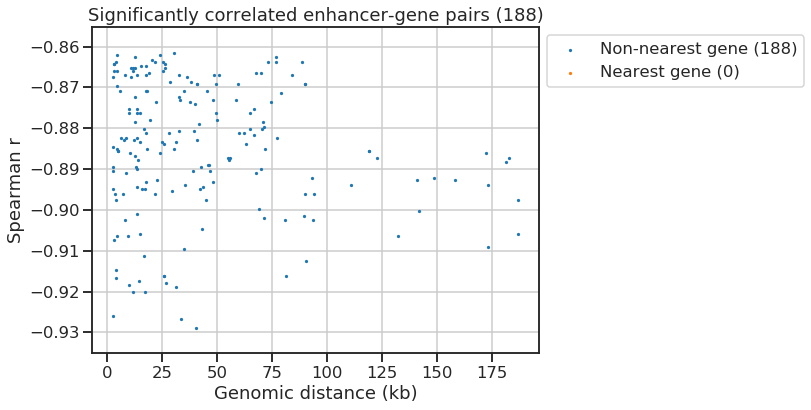

In [54]:
scale=1
fig, ax = plt.subplots(figsize=(8*scale, 6*scale))

# plot sig 
_df = top_sig[top_sig['gene_name']!=top_sig['nearest_gene']] 
n = len(_df)
ax.scatter(
    _df['dist']/1000, 
    _df['val'], 
    s=3,
    color='C0',
    alpha=1,
    label='Non-nearest gene ({})'.format(n),
)

# explained by nearest genes
# plot sig 
_df = top_sig[top_sig['gene_name']==top_sig['nearest_gene']] 
n = len(_df)
ax.scatter(
    _df['dist']/1000, 
    _df['val'], 
    s=3,
    color='C1',
    alpha=1,
    label='Nearest gene ({})'.format(n),
)


ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel('Genomic distance (kb)')
ax.set_ylabel('Spearman r')
ax.set_title('Significantly correlated enhancer-gene pairs ({})'.format(len(top_sig)))
plt.show()



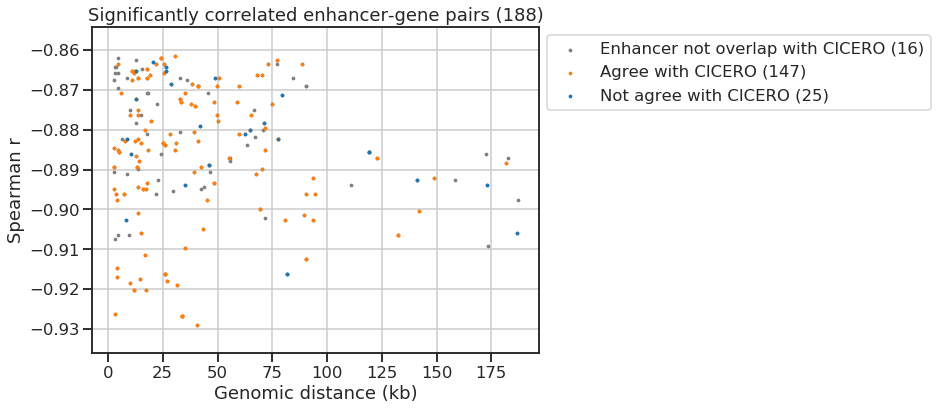

In [55]:
scale=1
fig, ax = plt.subplots(figsize=(8*scale, 6*scale))

s = 5 
# plot sig 
_df = top_sig 
n = len(_df) - len(comp_cicero)
ax.scatter(
    _df['dist']/1000, 
    _df['val'], 
    s=s,
    color='grey',
    alpha=1,
    label='Enhancer not overlap with CICERO ({})'.format(n),
)

# agree
_df = comp_cicero[comp_cicero['agree?']]
n = len(_df)
ax.scatter(
    _df['dist']/1000, 
    _df['val'], 
    s=s,
    color='C1',
    alpha=1,
    label='Agree with CICERO ({})'.format(n),
)

# not agree
_df = comp_cicero[~comp_cicero['agree?']]
n = len(_df)
ax.scatter(
    _df['dist']/1000, 
    _df['val'], 
    s=s,
    color='C0',
    alpha=1,
    label='Not agree with CICERO ({})'.format(n),
)

ax.legend(bbox_to_anchor=(1,1))

ax.set_xlabel('Genomic distance (kb)')
ax.set_ylabel('Spearman r')
ax.set_title('Significantly correlated enhancer-gene pairs ({})'.format(len(top_sig)))
plt.show()


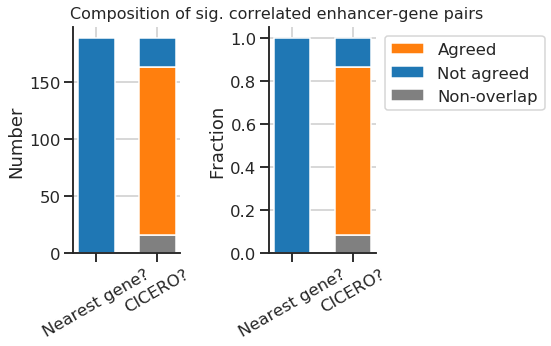

In [56]:
# numbers 
track1 = [0, 
          len(top_sig[top_sig['gene_name']==top_sig['nearest_gene']]), 
          len(top_sig[top_sig['gene_name']!=top_sig['nearest_gene']]),
         ]
track1_colors = ['C1', 'C0']
track1_labels = ['Agreed', 'Not agreed']
track2 = [0,
          len(top_sig) - len(comp_cicero), 
          len(comp_cicero[comp_cicero['agree?']==True]),
          len(comp_cicero[comp_cicero['agree?']==False]),
         ]
track2_colors = ['grey', 'C1', 'C0']
track2_labels = ['Non-overlap', 'Agreed', 'Not agreed']

with sns.plotting_context('talk'):
    fig, axs = plt.subplots(1, 2, figsize=(4*2,5))
    ax = axs[0]
    for i in range(len(track1)-1):
        color = track1_colors[i]
        ax.bar(0, track1[i+1], width=0.6, bottom=np.cumsum(track1)[i], color=color, label=track1_labels[i])
    for i in range(len(track2)-1):
        color = track2_colors[i]
        ax.bar(1, track2[i+1], width=0.6, bottom=np.cumsum(track2)[i], color=color, label=track2_labels[i])
    ax.set_xticklabels(['', 'Nearest gene?', 'CICERO?'], rotation=30)
    ax.set_ylabel('Number')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    
# plot 2 fraction 
track1 = np.array(track1)
track1 = track1/track1.sum()

track2 = np.array(track2)
track2 = track2/track2.sum()

with sns.plotting_context('talk'):
    ax = axs[1]
    for i in range(len(track1)-1):
        color = track1_colors[i]
        ax.bar(0, track1[i+1], width=0.6, bottom=np.cumsum(track1)[i], color=color, label=track1_labels[i])

    for i in range(len(track2)-1):
        color = track2_colors[i]
        ax.bar(1, track2[i+1], width=0.6, bottom=np.cumsum(track2)[i], color=color, label=track2_labels[i])
    ax.set_xticklabels(['', 'Nearest gene?', 'CICERO?'], rotation=30)
    ax.set_ylabel('Fraction')
    snmcseq_utils.nondup_legends(ax, bbox_to_anchor=(1,1))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    fig.suptitle('Composition of sig. correlated enhancer-gene pairs', fontsize=16)
    output_name = 'compare-to-nngenes-cicero' 
    fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
    fig.tight_layout()

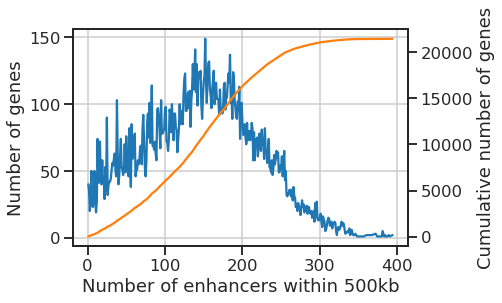

In [57]:
a = to_evals.groupby('gene').size().sort_values() #.values
a = a.value_counts().sort_index() #.values

with sns.plotting_context('talk'):
    fig, ax = plt.subplots()
    ax.plot(a.index.values, a.values)
    ax.set_xlabel('Number of enhancers within 500kb')
    ax.set_ylabel('Number of genes')
    ax2 = ax.twinx()
    ax2.plot(a.index.values, np.cumsum(a.values), color='C1', label='Cumulative')
    ax2.grid(False)
    ax2.set_ylabel('Cumulative number of genes')
    
    output_name = 'distribution-num-enhancers-per-gene' 
    fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')


### super enhancers 
start from ```to_evals```
- statistics on gene - cumulative effect of enhancers

In [58]:
th = -0.3
_tmp = to_evals.groupby('gene')
gene_score = _tmp.agg({'val': lambda x: np.sum(np.minimum(0, x-th))})
gene_score = gene_score.join(_tmp.agg({'val': lambda x: np.sum(x<th)}).fillna(0).astype(int),
                            lsuffix='_score', rsuffix='_num')

gene_score.sort_values('val_score').head()

,val_score,val_num
gene,,
ENSMUSG00000002107,-75.137110,205
ENSMUSG00000021373,-62.586152,211
ENSMUSG00000038132,-60.622222,232
ENSMUSG00000072679,-59.991078,203
ENSMUSG00000032503,-57.154406,159


In [59]:
_tmp = to_evals_shuffled.groupby('gene')
gene_score_shuffled = _tmp.agg({'val': lambda x: np.sum(np.minimum(0, x-th))})
gene_score_shuffled = gene_score_shuffled.join(_tmp.agg({'val': lambda x: np.sum(x<th)}).fillna(0).astype(int),
                            lsuffix='_score', rsuffix='_num')

gene_score_shuffled.sort_values('val_score').head()

,val_score,val_num
gene,,
ENSMUSG00000029364,-69.564477,237
ENSMUSG00000112126,-59.491133,197
ENSMUSG00000022237,-57.475862,176
ENSMUSG00000029798,-50.882485,207
ENSMUSG00000037708,-50.821073,189


In [60]:
# plt.plot(_X[snmcseq_utils.get_index_from_array(_x_features, gene_score.sort_values('val').index.values)].sum(axis=1)[:30])
# sns.distplot(_X[snmcseq_utils.get_index_from_array(_x_features, gene_score.sort_values('val').index.values)].sum(axis=1))
# plt.plot(_X[snmcseq_utils.get_index_from_array(_x_features, gene_score_shuffled.sort_values('val').index.values)].sum(axis=1)[:100])

In [61]:
corr_tracks = np.array([
    gene_score_shuffled['val_score'].values,
    gene_score['val_score'].values,
])

labels = np.array([
    'Gene score shuffled',
    'Gene score',
])

colors = np.array([
    'C0',
    'C1',
])

subsample_rates = np.array([
    1,
    1,
])

In [62]:
# FDR
bins_eval = np.linspace(-30, 0, 1000)

# background
x_bck = np.sort(corr_tracks[0])
y_bck = np.arange(len(x_bck))/len(x_bck)

# fore-ground - 1
x_fr = np.sort(corr_tracks[1])
y_fr = np.arange(len(x_fr))/len(x_fr)

# ratio 0
fdr_multi = fdr(bins_eval, x_bck, y_bck, x_fr, y_fr)

# plt.plot(bins_eval, fdr_multi)

    

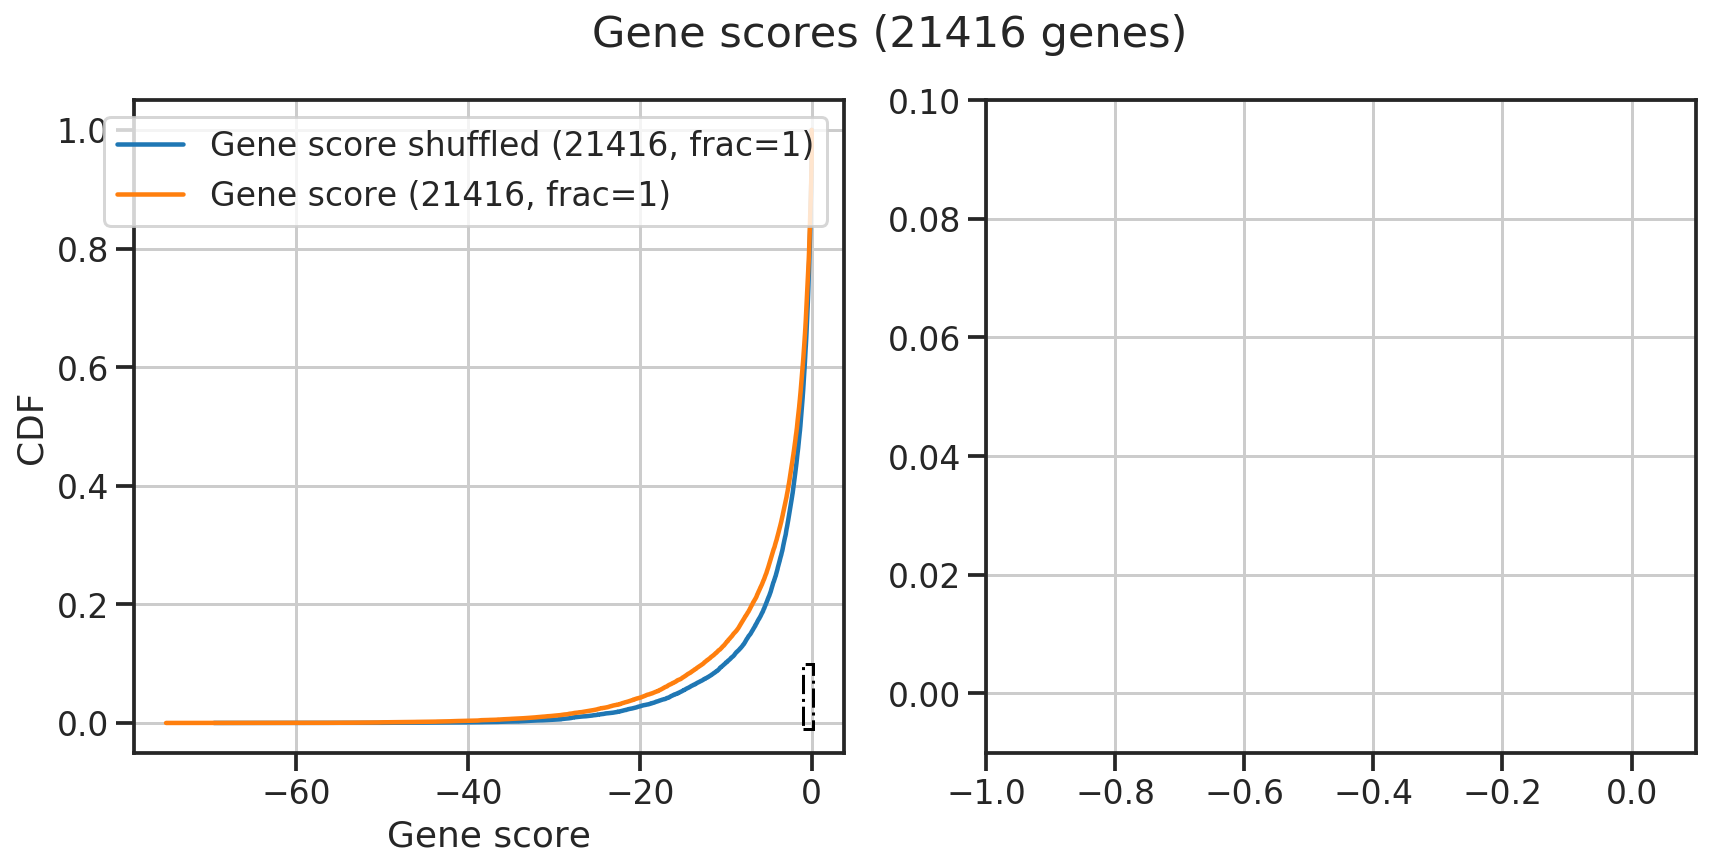

In [65]:
# plot
with sns.plotting_context('talk'):
    fig, axs = plt.subplots(1, 2, figsize=(7*2,6))
    ax = axs[0]
    for _x, label, color, subsample_rate in zip(corr_tracks, labels, colors, subsample_rates):
        linestyle = '-'
        ax.plot(np.sort(_x), np.arange(len(_x))/len(_x), 
                linestyle,
                label='{} ({}, frac={})'.format(label, len(_x), subsample_rate),
                color=color,
               )

    ax.legend()
    ax.set_xlabel('Gene score')
    ax.set_ylabel('CDF')
    
    xmin, xmax, ymin, ymax = -1, 0.1, -0.01, 0.1
    ax.add_patch(Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=None, color='black', linestyle='-.'))
    
    ax = axs[1]
    for _x, label, color, subsample_rate in zip(corr_tracks, labels, colors, subsample_rates):
        linestyle = '-'
        ax.plot(np.sort(_x), np.arange(len(_x))/len(_x), 
                linestyle,
                label='{} ({}, frac={})'.format(label, len(_x), subsample_rate),
                color=color,
               )

    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    
    
    fig.suptitle('Gene scores ({} genes)'.format(len(gene_score)), 
                )
    
#     fig.tight_layout()
    output_name = '30-super-enhancers-score' 
    fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
    plt.show()

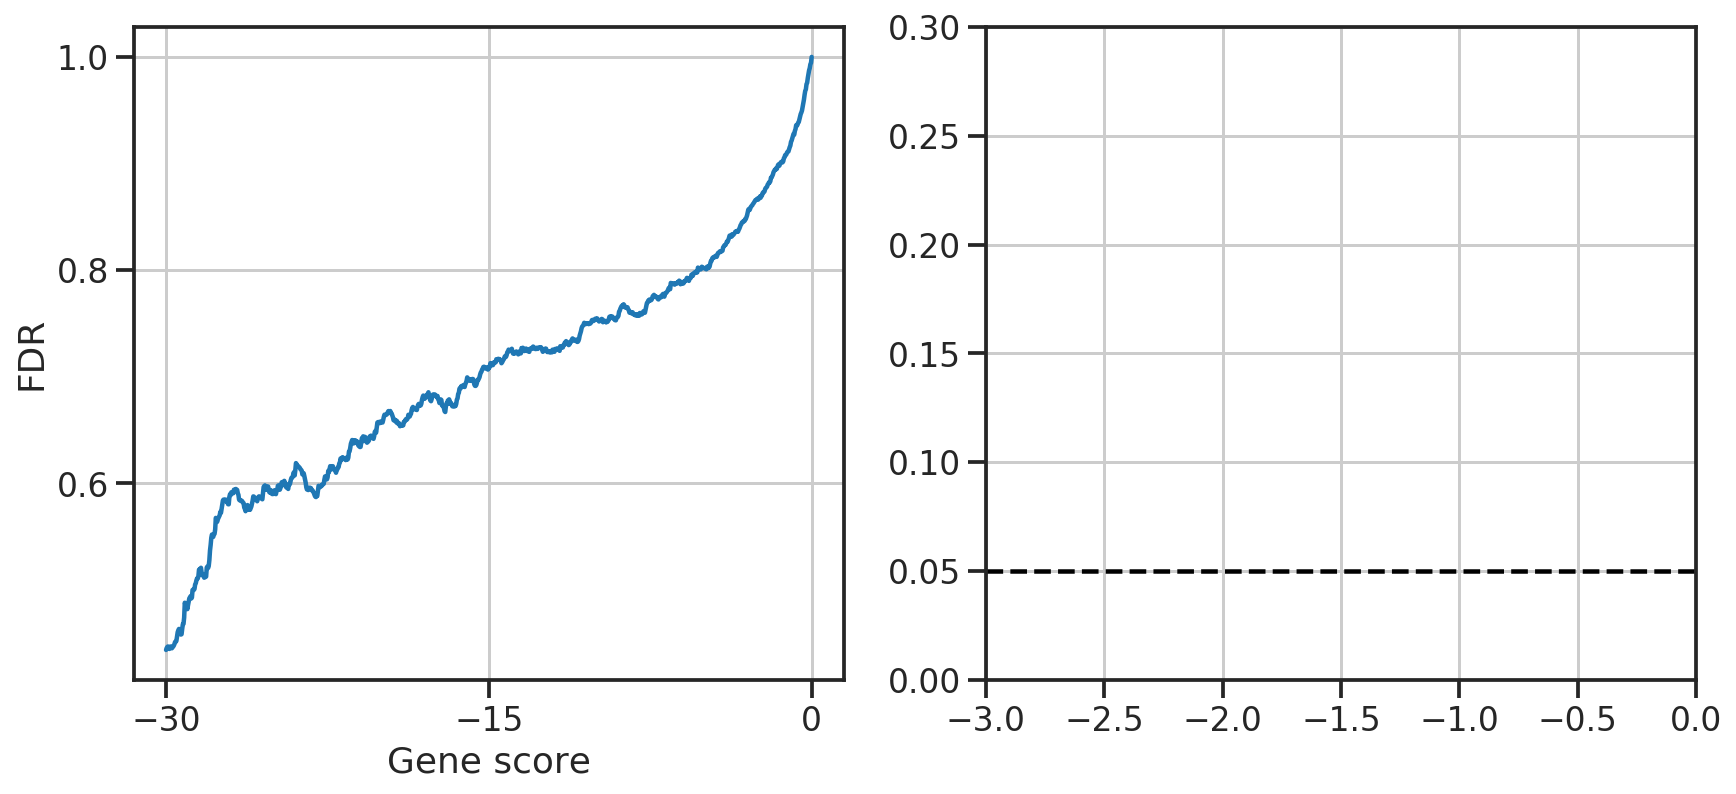

In [66]:
from matplotlib.patches import Rectangle
with sns.plotting_context('talk'):
    # inner box
#     xmin_1, xmax_1, ymin_1, ymax_1 = -0.8, 0.8, 0, 1 
    xmin, xmax, ymin, ymax = -3, 0, 0, 0.3 
    
    fig, axs = plt.subplots(1, 2, figsize=(7*2, 6*1))
    ax = axs[0]
    ax.plot(bins_eval, fdr_multi, 
#             label=labels[2], color=colors[2],
           )
#     ax.set_xlim([xmin_1, xmax_1])
#     ax.set_ylim([ymin_1, ymax_1])
#     ax.legend()
    ax.set_xlabel('Gene score')
    ax.set_ylabel('FDR')
    
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))
    ax.add_patch(Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=None, color='black', linestyle='-.'))

    ax = axs[1]
    ax.plot(bins_eval, fdr_multi, 
#             label=labels[2], color=colors[2],
           )
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    
    ax.axhline(0.05, color='black', linestyle='--')
    ax.xaxis.set_major_locator(plt.MaxNLocator(6))
    ax.yaxis.set_major_locator(plt.MaxNLocator(6))

    output_name = '31-super-enhancers-fdrs' 
    fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
    plt.show()

In [67]:
th = 0.3
gene_score['fdr'] = gene_score['val_score'].apply(lambda x: fdr(x, x_bck, y_bck, x_fr, y_fr))
res_multi = gene_score[gene_score['fdr']<th].sort_values('val_score')
print(res_multi.shape)
res_multi.head()

(70, 3)


,val_score,val_num,fdr
gene,,,
ENSMUSG00000002107,-75.137110,205,0.000000
ENSMUSG00000032530,-53.305364,181,0.291809
ENSMUSG00000038546,-53.298741,202,0.262790
ENSMUSG00000028086,-52.690859,198,0.247312
ENSMUSG00000099424,-52.341598,199,0.231146


### Lots of heatmaps 

In [68]:
th2 = -0.3
to_plot = to_evals[to_evals['val']<th2] 

to_plot.shape
to_plot.head()

,gene,ens,val,dist,pvalues,fdr<500kb,fdr<200kb,fdr<100kb
0,ENSMUSG00000000001,33736,-0.319650,995118,0.141100,0.745977,0.628894,0.555073
2,ENSMUSG00000000001,33739,-0.438424,987167,0.069513,0.678363,0.543472,0.462255
26,ENSMUSG00000000001,33764,-0.308703,723147,0.149207,0.751516,0.636234,0.563408
64,ENSMUSG00000000001,33803,-0.309250,372244,0.148801,0.751251,0.635881,0.563003
65,ENSMUSG00000000001,33804,-0.406130,370722,0.085849,0.697216,0.566872,0.487787


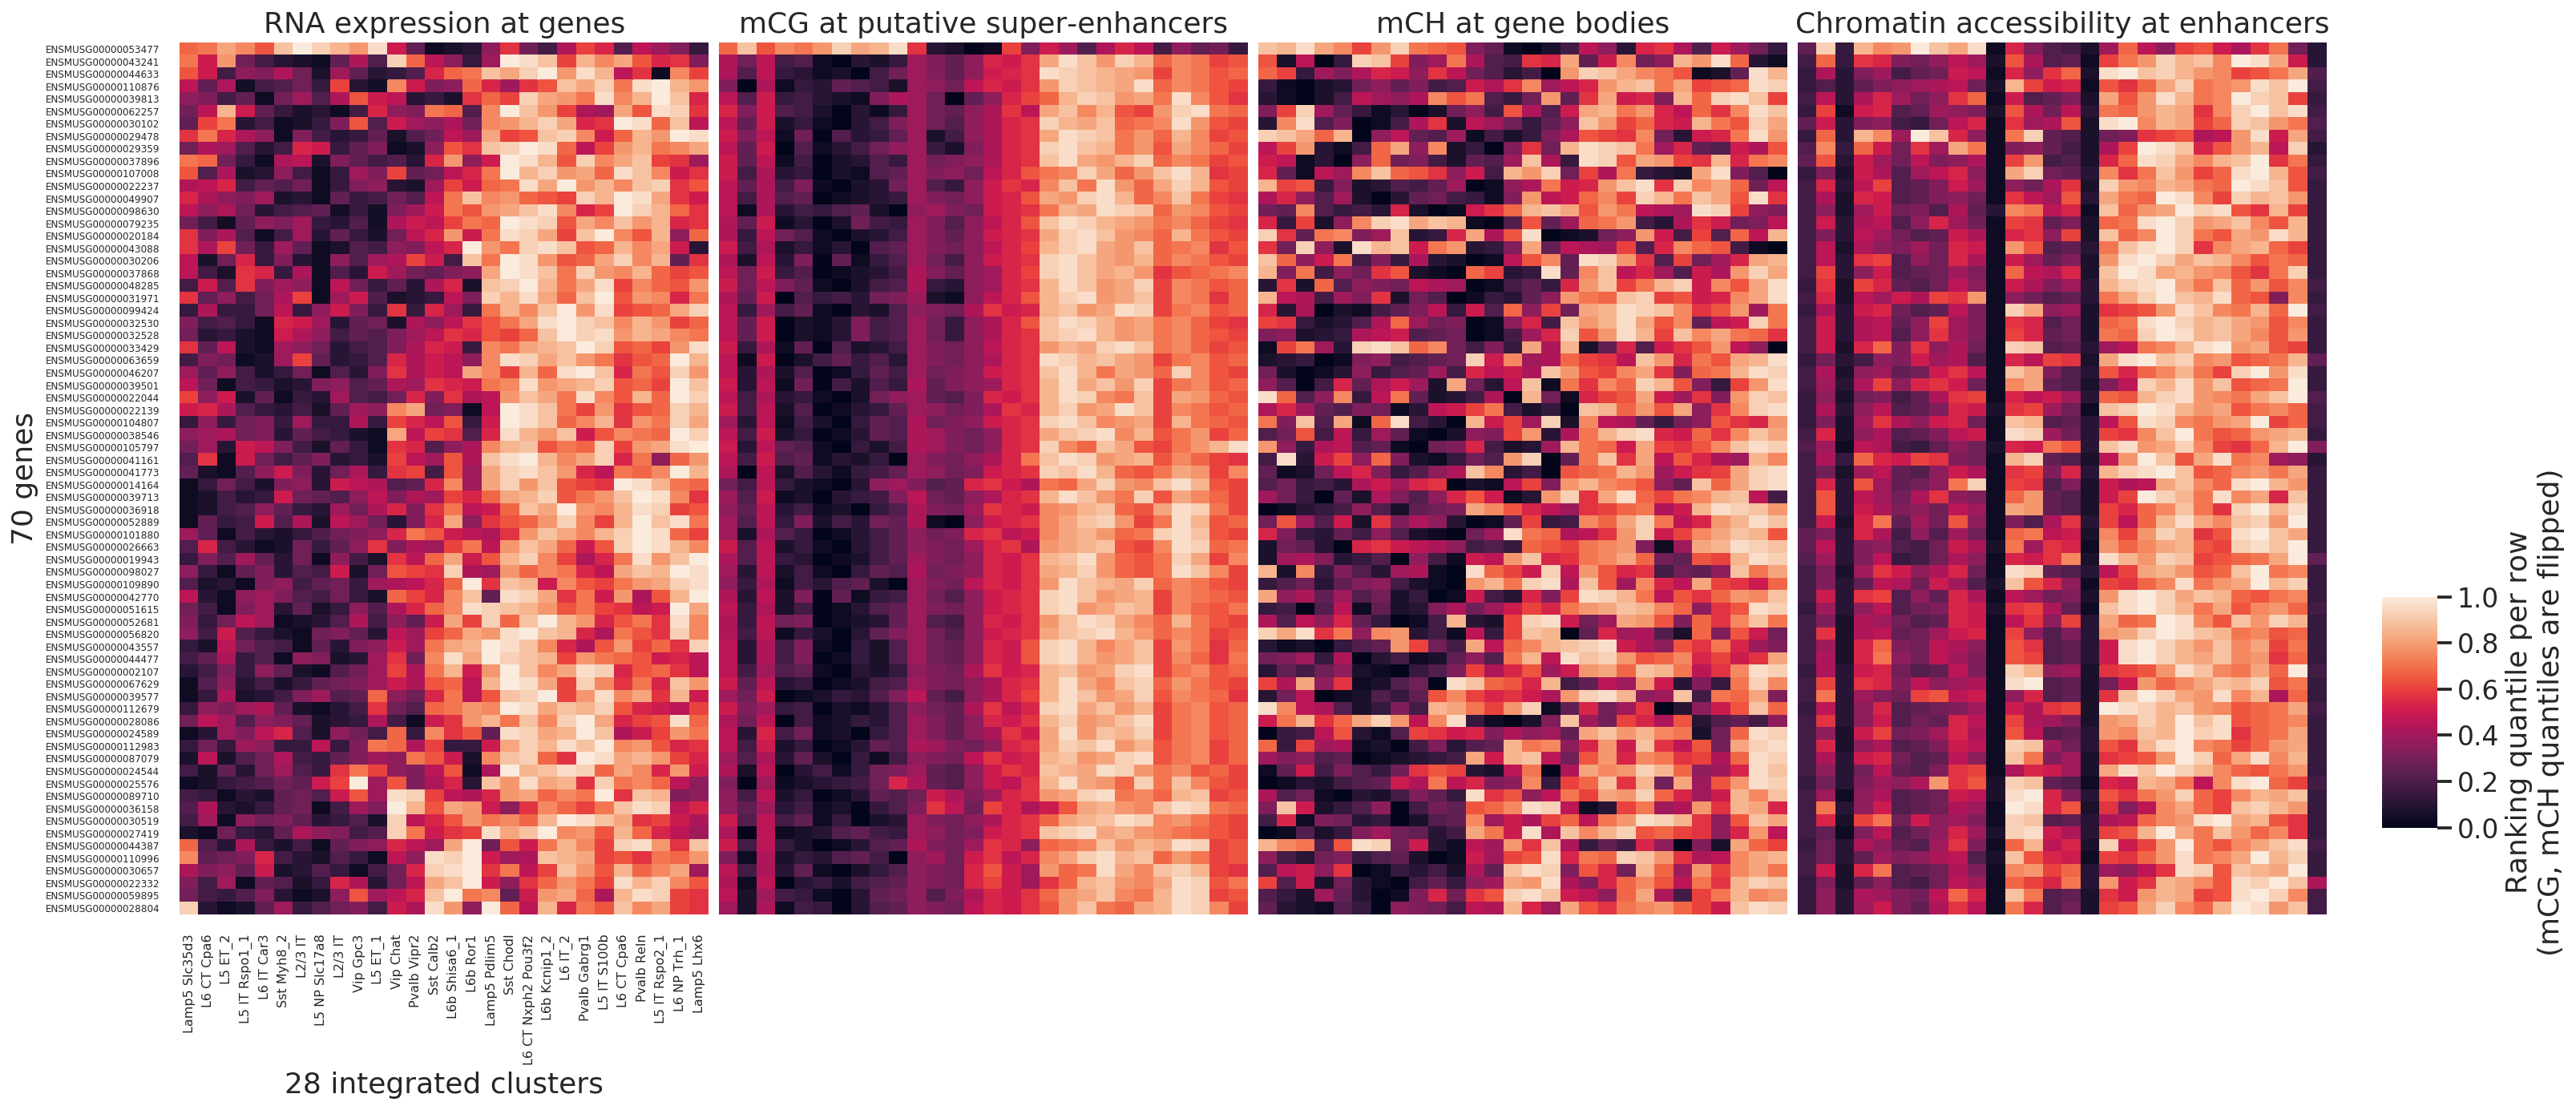

In [69]:
# heatmap of gene by cluster
# set_matplotlib_formats('pdf')

cmap = 'rocket'

# rna at genes 
rna_mat = gene_rna_clsts.loc[res_multi.index.values, clusters_selected]
rna_mat_norm = rna_mat.rank(pct=True, axis=1) #.apply(zscore, axis=1)

# row gene
Z = sch.linkage(rna_mat_norm, method='average', metric='euclidean', optimal_ordering=True)
dn = sch.dendrogram(Z, no_plot=True)

# col clst
Z = sch.linkage(rna_mat_norm.T, method='average', metric='euclidean', optimal_ordering=True)
dn_clst = sch.dendrogram(Z, no_plot=True)

genes_ordered = rna_mat_norm.index.values[dn['leaves']]
ens_ordered = to_plot.set_index('gene').loc[genes_ordered]

# mCH at genes
mch_mat = gene_mch_clsts.reindex(genes_ordered).loc[:, clusters_selected]

# mC at enhancers 
mcc_mat = enh_mcg_clsts.loc[ens_ordered['ens'].values, clusters_selected] 
mcc_mat['gene'] = ens_ordered.index.values
mcc_mat = mcc_mat.groupby('gene').mean().loc[genes_ordered]

# # ATAC at enhancers
atac_mat = enh_atac_clsts.loc[ens_ordered['ens'].values, clusters_selected] 
atac_mat['gene'] = ens_ordered.index.values
atac_mat = atac_mat.groupby('gene').mean().loc[genes_ordered]

with sns.plotting_context('talk'), sns.axes_style('white'):
    fig, axs = plt.subplots(1, 4, figsize=(6*4,10))
    cbar_ax = fig.add_axes([.92, .2, .02, .2])
    
    ax = axs[0]
    g = sns.heatmap(rna_mat_norm.iloc[dn['leaves'], dn_clst['leaves']],
                    xticklabels=clusters_selected_labels[dn_clst['leaves']], 
#                     xticklabels=False,
                    yticklabels=True,
                    vmin=0, vmax=1,
                    ax=ax,
                    cmap=cmap,
                    cbar_ax=cbar_ax,
                    cbar_kws={'fraction': 0.05, 
                              'label': 'Ranking quantile per row\n(mCG, mCH quantiles are flipped)',
                             }, 
                   )
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=6)
    ax.set_title('RNA expression at genes')
    ax.set_xlabel('{} integrated clusters'.format(len(dn_clst['leaves'])))
    ax.set_ylabel('{} genes'.format(len(dn['leaves'])))

    ax = axs[1]
    g = sns.heatmap((1-mcc_mat.rank(axis=1, pct=True)).iloc[:, dn_clst['leaves']], 
                    yticklabels=False,
                    xticklabels=False, 
                    vmin=0, vmax=1,
                    cbar=False,
                    cmap=cmap,
                    ax=ax)
    ax.set_title('mCG at putative super-enhancers')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    ax = axs[2]
    g = sns.heatmap((1-mch_mat.rank(axis=1, pct=True)).iloc[:, dn_clst['leaves']],
                    yticklabels=False,
                    xticklabels=False, 
                    vmin=0, vmax=1,
                    cbar=False,
                    cmap=cmap,
                    ax=ax)
    ax.set_title('mCH at gene bodies')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    ax = axs[3]
    g = sns.heatmap(atac_mat.rank(axis=1, pct=True).iloc[:, dn_clst['leaves']], 
                    yticklabels=False,
                    xticklabels=False, 
                    vmin=0, vmax=1,
                    cbar=False,
                    cmap=cmap,
                    ax=ax)
    ax.set_title('Chromatin accessibility at enhancers')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
    ax.set_xlabel('')
    ax.set_ylabel('')

    fig.subplots_adjust(wspace=0.02, hspace=0.08)
    
    output_name = '32-heatmap-examples-super-enhancers' 
    fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
    plt.show()

In [70]:
gene = 'Kcnc1'
gid = df_genes.groupby('gene_name').first().loc[gene, 'gid']
gid

'ENSMUSG00000058975'

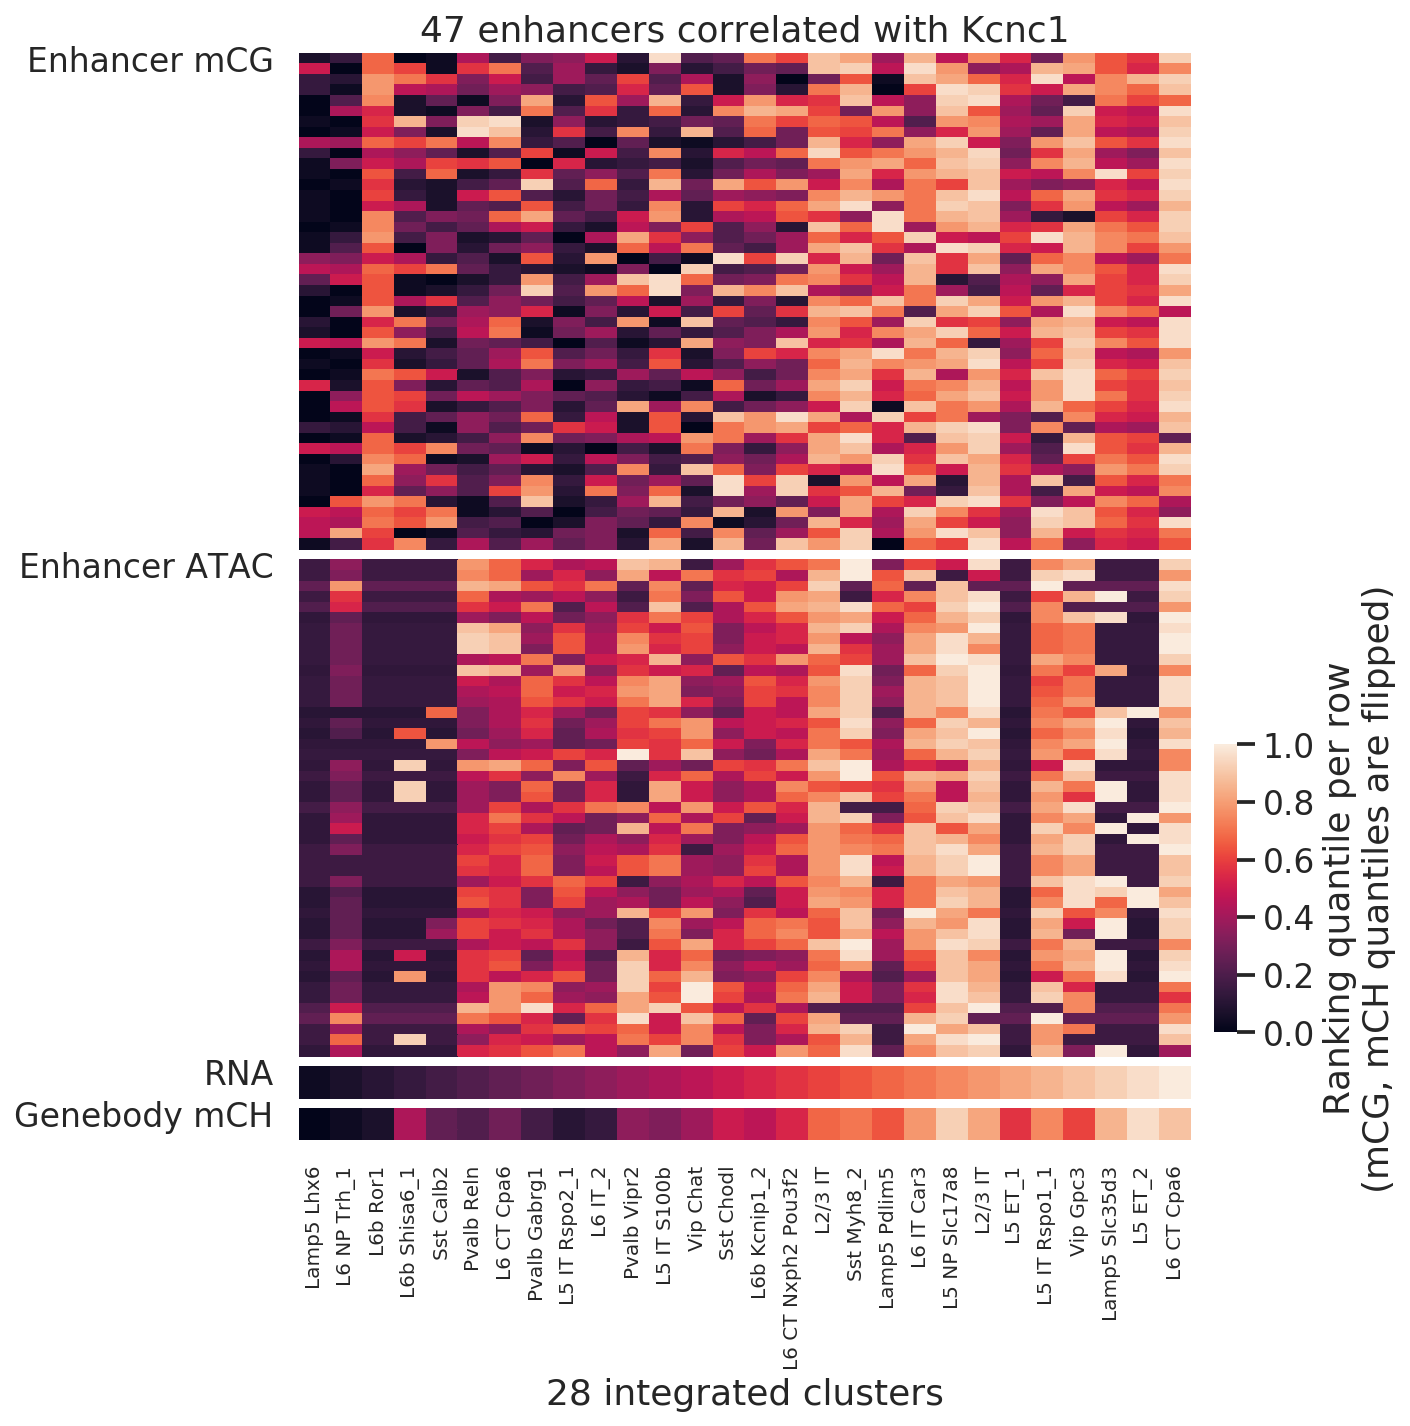

In [71]:
# heatmap of gene by cluster

cmap = 'rocket'
gene = 'Kcnc1'
gene = df_genes.groupby('gene_name').first().loc[gene, 'gid']

# rna at genes 
rna_mat = gene_rna_clsts.loc[[gene], clusters_selected]
rna_mat_norm = rna_mat.rank(pct=True, axis=1) #.apply(zscore, axis=1)


# ordered
ens_ordered = to_plot.set_index('gene').loc[gene]
clst_idx_ordered = np.argsort(rna_mat_norm.values.flatten())

# mCH at genes
mch_mat = gene_mch_clsts.loc[[gene], clusters_selected]

# mC at enhancers 
mcc_mat = enh_mcg_clsts.loc[ens_ordered['ens'].values, clusters_selected] 

# # ATAC at enhancers
atac_mat = enh_atac_clsts.loc[ens_ordered['ens'].values, clusters_selected] 

# organize heatmap to plot
n_repeats = 3
blank_repeats = 1

heatmap_all = np.vstack([
    # mcg
    (1-mcc_mat.rank(axis=1, pct=True)).iloc[:, clst_idx_ordered],    
    np.repeat(np.full(len(clst_idx_ordered), np.nan).reshape(1, -1), blank_repeats, axis=0),
    
    # atac
     atac_mat.rank(axis=1, pct=True).iloc[:, clst_idx_ordered],
    np.repeat(np.full(len(clst_idx_ordered), np.nan).reshape(1, -1), blank_repeats, axis=0),
    
    # rna
    np.repeat(rna_mat_norm.iloc[:, clst_idx_ordered].values, n_repeats, axis=0),
    np.repeat(np.full(len(clst_idx_ordered), np.nan).reshape(1, -1), blank_repeats, axis=0),
    
    # mch
    np.repeat((1-mch_mat.rank(axis=1, pct=True)).iloc[:, clst_idx_ordered].values, n_repeats, axis=0),
])

yticklabels = np.hstack([
    ['Enhancer mCG']*(len(mcc_mat) + blank_repeats),
    ['Enhancer ATAC']*(len(atac_mat) + blank_repeats),
    ['RNA']*(n_repeats + blank_repeats),
    ['Genebody mCH']*n_repeats,
])
yticklabels = snmcseq_utils.dedup_array_elements(yticklabels)

with sns.plotting_context('talk'), sns.axes_style('white'):
    fig, ax = plt.subplots(1, 1, figsize=(8,10))
    cbar_ax = fig.add_axes([.92, .2, .02, .2])
    
    g = sns.heatmap(heatmap_all, 
                    xticklabels=clusters_selected_labels[clst_idx_ordered],
                    yticklabels=yticklabels, 
                    vmin=0, vmax=1,
                    cbar_ax=cbar_ax,
                    cbar_kws={'fraction': 0.05, 
                              'label': 'Ranking quantile per row\n(mCG, mCH quantiles are flipped)',
                             }, 
                    cmap=cmap,
                    ax=ax)

    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
    ax.set_xlabel('{} integrated clusters'.format(mcc_mat.shape[1]))
    ax.set_title('{} enhancers correlated with {}'.format(len(mcc_mat), gid_to_name.loc[gene]))
    
    output_name = '33-heatmap-1example-super-enhancers' 
    fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
#     fig.subplots_adjust(wspace=0.02, hspace=0.08)
    plt.show()

In [72]:
# bed = regions.set_index('index').loc[ens_ordered['ens'].values].reset_index()[['chrom', 'start', 'end', 'index']]
# bed.to_csv('/cndd/fangming/CEMBA/data/MOp_all/enhancers_may1/enhancers_june19/kcnc1_enhancers.tsv', 
#            sep='\t', na_rep='NA',
#            header=False, index=False, 
#           )

In [73]:
# bed['len'] = bed['end'] - bed['start']
# bed.sort_values('len').tail()

### one example correlation

In [74]:
to_evals.sort_values('val').head()

,gene,ens,val,dist,pvalues,fdr<500kb,fdr<200kb,fdr<100kb
1600928,ENSMUSG00000040133,22029,-0.980296,18964,5.446448e-07,0.544645,0.544645,0.544645
91082,ENSMUSG00000005102,22029,-0.978106,34163,5.446448e-07,0.489416,0.421134,0.337378
969343,ENSMUSG00000029094,50845,-0.947455,49444,5.446448e-07,0.233051,0.140938,0.077804
465352,ENSMUSG00000022099,139358,-0.946360,686734,5.446448e-07,0.229666,0.138794,0.076439
134831,ENSMUSG00000008575,42843,-0.945813,246068,5.446448e-07,0.228010,0.137747,0.075774


In [77]:
gene = 'ENSMUSG00000040133'
to_evals[to_evals['gene']==gene].sort_values('val').head()

,gene,ens,val,dist,pvalues,fdr<500kb,fdr<200kb,fdr<100kb
1600928,ENSMUSG00000040133,22029,-0.980296,18964,5.446448e-07,0.544645,0.544645,0.544645
1600904,ENSMUSG00000040133,22005,-0.911877,213432,5.446448e-07,0.055038,0.027300,0.013383
1600931,ENSMUSG00000040133,22032,-0.891078,8897,3.687084e-06,0.092348,0.046528,0.025677
1600927,ENSMUSG00000040133,22028,-0.853859,27248,4.008639e-05,0.200649,0.098463,0.058435
1600929,ENSMUSG00000040133,22030,-0.808429,16198,2.598091e-04,0.294150,0.161756,0.105713


Gpr176


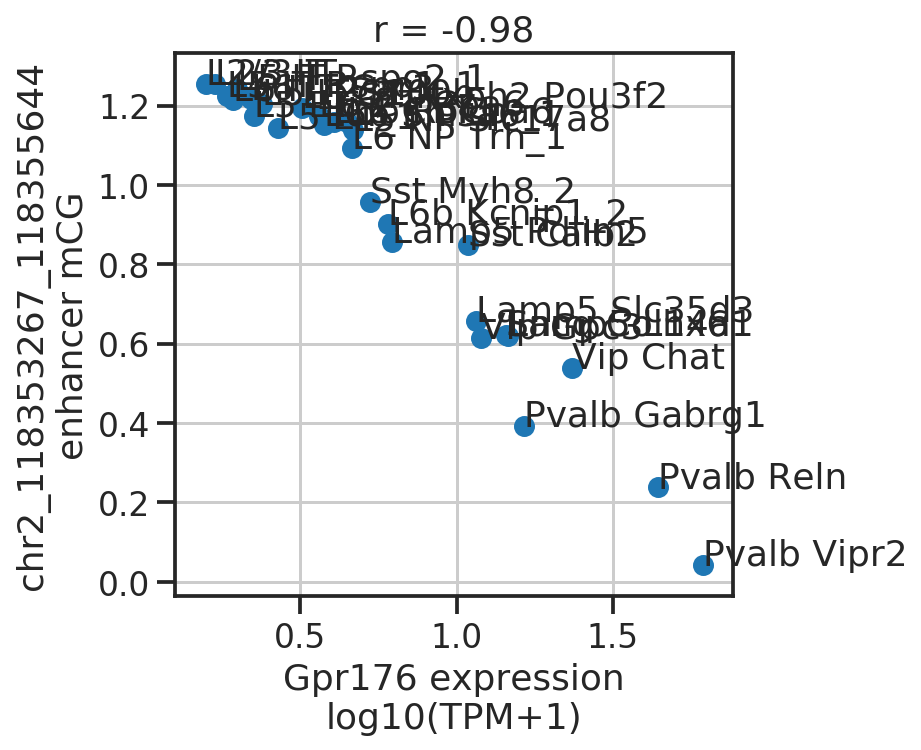

In [80]:

print(gid_to_name.loc[gene])
enh = 22029
enh_name = '_'.join(regions.set_index('index').loc[enh][['chr', 'start', 'end']].astype(str).tolist())

# gene = df_genes.groupby('gene_name').first().loc[gene, 'gid']
# gene = 'Slc1a2'
# enh = 73274
# enh_name = 'chr'+'_'.join(regions.set_index('index').loc[enh].astype(str).tolist())


_x = gene_rna_clsts.loc[gene, clusters_selected]
_y = enh_mcg_clsts.loc[enh, clusters_selected]
_c = pd.Series(clst_annot)[clusters_selected]

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(_x.values, _y.values)
r, p = stats.spearmanr(_x.values, _y.values)
ax.set_title('r = {:.2f}'.format(r))
for __x, __y, __c in zip(_x, _y, _c):
    ax.text(__x, __y, __c)
ax.set_ylabel('{}\nenhancer mCG'.format(enh_name))
ax.set_xlabel('{} expression\nlog10(TPM+1)'.format(gid_to_name.loc[gene]))

output_name = '34_example_corr' 
fig.savefig(output_figures.format(output_name, 'pdf'), bbox_inches='tight')
plt.show()

### linear model

In [ ]:
# import statsmodels.api as sm
# from sklearn import metrics

# set_n_enhs = 10
# alphas = [1e-2, 1e-3, 1e-4, 1e-5]
# r2_linears = {}
# r2_linears_shuffled = {}

# for alpha in alphas:
#     r2_linear = []
#     # for each gene build a linear model
#     for i, (gene, df_sub) in enumerate(to_evals.groupby('gene')):
#         if i % 1000 == 0:
#             print(i)

#         enss = df_sub.sort_values('dist').head(set_n_enhs)['ens'].values
#         y = gene_rna_clsts.loc[gene]
#         X = pd.concat([enh_mcg_clsts.loc[enss].T, enh_atac_clsts.loc[enss].T], axis=1)
#         n_enhs = int(X.shape[1]/2)

#         X['const'] = 1
#         # linear model
#         res = sm.OLS(y.values, X.values).fit_regularized(alpha=alpha)
# #         r2 = res.rsquared
#         r2 = metrics.r2_score(y.values, res.predict())
#         r2_linear.append({'gene': gene, 
#                           'n_enhs': n_enhs,
#                           'r2': r2, 
#                          })
#     r2_linear = pd.DataFrame(r2_linear) 
#     r2_linears[alpha] = r2_linear

#     r2_linear_shuffled = []
#     # for each gene build a linear model
#     for i, (gene, df_sub) in enumerate(to_evals_shuffled.groupby('gene')):
#         if i % 1000 == 0:
#             print(i)

#         enss = df_sub.sort_values('dist').head(set_n_enhs)['ens'].values
#         y = gene_rna_clsts.loc[gene]
#         X = pd.concat([enh_mcg_clsts.loc[enss].T, enh_atac_clsts.loc[enss].T], axis=1)
#         n_enhs = int(X.shape[1]/2)

#         X['const'] = 1
#         # linear model
#         res = sm.OLS(y.values, X.values).fit_regularized(alpha=alpha)
# #         r2 = res.rsquared
#         r2 = metrics.r2_score(y.values, res.predict())
#         r2_linear_shuffled.append({'gene': gene, 
#                           'n_enhs': n_enhs,
#                           'r2': r2, 
#                          })
#     r2_linear_shuffled = pd.DataFrame(r2_linear_shuffled) 
#     r2_linears_shuffled[alpha] = r2_linear_shuffled


In [ ]:
# list(r2_linears.keys())

In [ ]:
# r2_linear = r2_linears[0.1]
# r2_linear_shuffled = r2_linears_shuffled[0.1]

# fig, axs = plt.subplots(1, 2, figsize=(5*2, 4))
# ax = axs[0]
# sns.distplot(r2_linear['r2'], ax=ax, label='raw')
# sns.distplot(r2_linear_shuffled['r2'], ax=ax, label='shuffled')
# ax.set_ylabel('Density')
# ax.set_xlabel('R_squared')

# ax = axs[1]
# snmcseq_utils.gen_cdf(r2_linear['r2'].values, flip=True, ax=ax, label='raw')
# snmcseq_utils.gen_cdf(r2_linear_shuffled['r2'].values, flip=True, ax=ax, label='shuffled')
# ax.set_ylabel('Cumulative fraction')
# ax.set_xlabel('R_squared')
# ax.legend(bbox_to_anchor=(1,1))

# fig.suptitle("Gene RNA ~ 1 + enhancer mCGs and enhancer ATAC (n=10)", fontsize=18)
# fig.tight_layout()
# fig.savefig(output_figures.format('liear_model_gene_mCH', 'pdf'))
# plt.show()

In [76]:
# fig, axs = plt.subplots(1, 2, figsize=(5*2, 4))
# ax = axs[0]
# sns.distplot(r2_linear['r2'], ax=ax, label='raw')
# sns.distplot(r2_linear_shuffled['r2'], ax=ax, label='shuffled')
# ax.set_ylabel('Density')
# ax.set_xlabel('R_squared')

# ax = axs[1]
# snmcseq_utils.gen_cdf(r2_linear['r2'].values, flip=True, ax=ax, label='raw')
# snmcseq_utils.gen_cdf(r2_linear_shuffled['r2'].values, flip=True, ax=ax, label='shuffled')
# ax.set_ylabel('Cumulative fraction')
# ax.set_xlabel('R_squared')
# ax.legend(bbox_to_anchor=(1,1))

# fig.suptitle("Gene RNA ~ 1 + enhancer mCGs (n=10)", fontsize=18)
# fig.tight_layout()
# fig.savefig(output_figures.format('liear_model_gene_mCH', 'pdf'))
# plt.show()